In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Importing keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
np.random.seed(7)

C:\Users\lenovo\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Text preprocessing

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:36<00:00, 1684.71it/s]


In [13]:
final['CleanedText']=preprocessed_reviews

# Data preparation

In [14]:
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...


In [15]:
X = data['CleanedText'].values
y = data['Score']

In [16]:
#Vocabulary
count_vect = CountVectorizer() 
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  116756


In [17]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
    for word in sent.split():
        corpus.setdefault(word,[])
        corpus[word].append(ind)
        ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
    freq.append(len(corpus[w]))

In [18]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
    word_rank[vocabulary[i]] = rank
    rank +=1

In [19]:
data = []
for sent in X:
    row = []
    for word in sent.split():
        if(len(word)>1):
            row.append(word_rank[word])
    data.append(row)

#Splitting the data 
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.3, random_state=42)

# Lstm one layer

In [20]:
#padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(254919, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    43    36    21    17   425   281   272   141     4   308
   304    89  4220   134  1306  1380   137     8   166    80   272   179
  1380    21    68   141  6207   182   276    66    96   285    56   396
  3271    85   406   304   727   134     2  4097 12684   436     1  4220
   132   304  8709   973     2  4513  3051   212  1773   123   336    16
   302  1380   272   179]


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

In [22]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
epochs = 10

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           3736224   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,789,525
Trainable params: 3,789,525
Non-trainable params: 0
___________

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Instructions for updating:
Use tf.cast instead.
Train on 254919 samples, validate on 109252 samples
Epoch 1/10


104448/254919 [===========>..................] - ETA: 34:26 - loss: 0.6933 - acc: 0.51 - ETA: 21:04 - loss: 0.6906 - acc: 0.67 - ETA: 16:56 - loss: 0.6883 - acc: 0.72 - ETA: 14:51 - loss: 0.6854 - acc: 0.75 - ETA: 13:36 - loss: 0.6823 - acc: 0.77 - ETA: 12:49 - loss: 0.6789 - acc: 0.78 - ETA: 12:12 - loss: 0.6748 - acc: 0.79 - ETA: 11:44 - loss: 0.6704 - acc: 0.79 - ETA: 11:20 - loss: 0.6646 - acc: 0.80 - ETA: 10:58 - loss: 0.6581 - acc: 0.80 - ETA: 10:39 - loss: 0.6490 - acc: 0.80 - ETA: 10:25 - loss: 0.6366 - acc: 0.81 - ETA: 10:13 - loss: 0.6234 - acc: 0.81 - ETA: 10:02 - loss: 0.6107 - acc: 0.81 - ETA: 9:51 - loss: 0.6020 - acc: 0.8195 - ETA: 9:41 - loss: 0.5930 - acc: 0.820 - ETA: 9:32 - loss: 0.5832 - acc: 0.821 - ETA: 9:24 - loss: 0.5762 - acc: 0.822 - ETA: 9:18 - loss: 0.5711 - acc: 0.822 - ETA: 9:13 - loss: 0.5647 - acc: 0.824 - ETA: 9:07 - loss: 0.5587 - acc: 0.826 - ETA: 9:01 - loss: 0.5552 - acc: 0.825 - ETA: 8:57 - loss: 0.5501 - acc: 0.826 - ETA: 8:53 - loss: 0.5459 - acc

208896/254919 [=======================>......] - ETA: 5:02 - loss: 0.2973 - acc: 0.884 - ETA: 5:01 - loss: 0.2968 - acc: 0.884 - ETA: 5:00 - loss: 0.2962 - acc: 0.884 - ETA: 4:59 - loss: 0.2958 - acc: 0.884 - ETA: 4:58 - loss: 0.2953 - acc: 0.884 - ETA: 4:57 - loss: 0.2947 - acc: 0.885 - ETA: 4:55 - loss: 0.2941 - acc: 0.885 - ETA: 4:54 - loss: 0.2937 - acc: 0.885 - ETA: 4:53 - loss: 0.2933 - acc: 0.885 - ETA: 4:52 - loss: 0.2927 - acc: 0.885 - ETA: 4:51 - loss: 0.2924 - acc: 0.886 - ETA: 4:50 - loss: 0.2919 - acc: 0.886 - ETA: 4:49 - loss: 0.2914 - acc: 0.886 - ETA: 4:48 - loss: 0.2909 - acc: 0.886 - ETA: 4:47 - loss: 0.2904 - acc: 0.886 - ETA: 4:46 - loss: 0.2901 - acc: 0.886 - ETA: 4:45 - loss: 0.2896 - acc: 0.887 - ETA: 4:44 - loss: 0.2893 - acc: 0.887 - ETA: 4:43 - loss: 0.2889 - acc: 0.887 - ETA: 4:42 - loss: 0.2885 - acc: 0.887 - ETA: 4:41 - loss: 0.2881 - acc: 0.887 - ETA: 4:40 - loss: 0.2876 - acc: 0.887 - ETA: 4:39 - loss: 0.2871 - acc: 0.888 - ETA: 4:38 - loss: 0.2868 - acc:

254919/254919 [==============================] - ETA: 1:31 - loss: 0.2446 - acc: 0.904 - ETA: 1:30 - loss: 0.2445 - acc: 0.904 - ETA: 1:29 - loss: 0.2444 - acc: 0.904 - ETA: 1:28 - loss: 0.2442 - acc: 0.904 - ETA: 1:27 - loss: 0.2441 - acc: 0.904 - ETA: 1:25 - loss: 0.2438 - acc: 0.904 - ETA: 1:24 - loss: 0.2437 - acc: 0.904 - ETA: 1:23 - loss: 0.2435 - acc: 0.904 - ETA: 1:22 - loss: 0.2434 - acc: 0.904 - ETA: 1:21 - loss: 0.2432 - acc: 0.904 - ETA: 1:20 - loss: 0.2431 - acc: 0.904 - ETA: 1:19 - loss: 0.2430 - acc: 0.905 - ETA: 1:18 - loss: 0.2428 - acc: 0.905 - ETA: 1:17 - loss: 0.2427 - acc: 0.905 - ETA: 1:16 - loss: 0.2426 - acc: 0.905 - ETA: 1:15 - loss: 0.2424 - acc: 0.905 - ETA: 1:14 - loss: 0.2423 - acc: 0.905 - ETA: 1:13 - loss: 0.2422 - acc: 0.905 - ETA: 1:12 - loss: 0.2421 - acc: 0.905 - ETA: 1:11 - loss: 0.2420 - acc: 0.905 - ETA: 1:10 - loss: 0.2418 - acc: 0.905 - ETA: 1:09 - loss: 0.2417 - acc: 0.905 - ETA: 1:08 - loss: 0.2414 - acc: 0.905 - ETA: 1:07 - loss: 0.2412 - acc:

104448/254919 [===========>..................] - ETA: 8:27 - loss: 0.1703 - acc: 0.935 - ETA: 8:36 - loss: 0.1680 - acc: 0.938 - ETA: 8:38 - loss: 0.1575 - acc: 0.943 - ETA: 8:31 - loss: 0.1602 - acc: 0.940 - ETA: 8:33 - loss: 0.1618 - acc: 0.939 - ETA: 8:34 - loss: 0.1631 - acc: 0.936 - ETA: 8:29 - loss: 0.1598 - acc: 0.937 - ETA: 8:25 - loss: 0.1595 - acc: 0.937 - ETA: 8:26 - loss: 0.1600 - acc: 0.936 - ETA: 8:28 - loss: 0.1617 - acc: 0.935 - ETA: 8:25 - loss: 0.1635 - acc: 0.935 - ETA: 8:22 - loss: 0.1637 - acc: 0.935 - ETA: 8:23 - loss: 0.1614 - acc: 0.936 - ETA: 8:24 - loss: 0.1599 - acc: 0.936 - ETA: 8:21 - loss: 0.1604 - acc: 0.934 - ETA: 8:19 - loss: 0.1581 - acc: 0.935 - ETA: 8:18 - loss: 0.1604 - acc: 0.935 - ETA: 8:16 - loss: 0.1600 - acc: 0.935 - ETA: 8:14 - loss: 0.1597 - acc: 0.936 - ETA: 8:14 - loss: 0.1586 - acc: 0.937 - ETA: 8:18 - loss: 0.1580 - acc: 0.937 - ETA: 8:19 - loss: 0.1585 - acc: 0.937 - ETA: 8:20 - loss: 0.1601 - acc: 0.937 - ETA: 8:22 - loss: 0.1602 - acc:

208896/254919 [=======================>......] - ETA: 5:01 - loss: 0.1610 - acc: 0.938 - ETA: 5:00 - loss: 0.1610 - acc: 0.938 - ETA: 4:59 - loss: 0.1608 - acc: 0.938 - ETA: 4:58 - loss: 0.1606 - acc: 0.938 - ETA: 4:57 - loss: 0.1607 - acc: 0.938 - ETA: 4:56 - loss: 0.1606 - acc: 0.938 - ETA: 4:55 - loss: 0.1604 - acc: 0.938 - ETA: 4:54 - loss: 0.1605 - acc: 0.938 - ETA: 4:53 - loss: 0.1605 - acc: 0.938 - ETA: 4:52 - loss: 0.1604 - acc: 0.938 - ETA: 4:51 - loss: 0.1604 - acc: 0.938 - ETA: 4:50 - loss: 0.1603 - acc: 0.938 - ETA: 4:48 - loss: 0.1605 - acc: 0.938 - ETA: 4:47 - loss: 0.1606 - acc: 0.938 - ETA: 4:46 - loss: 0.1606 - acc: 0.938 - ETA: 4:45 - loss: 0.1606 - acc: 0.938 - ETA: 4:44 - loss: 0.1605 - acc: 0.938 - ETA: 4:43 - loss: 0.1604 - acc: 0.938 - ETA: 4:42 - loss: 0.1605 - acc: 0.938 - ETA: 4:41 - loss: 0.1605 - acc: 0.938 - ETA: 4:40 - loss: 0.1606 - acc: 0.938 - ETA: 4:39 - loss: 0.1605 - acc: 0.938 - ETA: 4:38 - loss: 0.1606 - acc: 0.938 - ETA: 4:37 - loss: 0.1607 - acc:

254919/254919 [==============================] - ETA: 1:30 - loss: 0.1637 - acc: 0.937 - ETA: 1:29 - loss: 0.1637 - acc: 0.937 - ETA: 1:28 - loss: 0.1637 - acc: 0.937 - ETA: 1:27 - loss: 0.1637 - acc: 0.937 - ETA: 1:26 - loss: 0.1637 - acc: 0.937 - ETA: 1:25 - loss: 0.1637 - acc: 0.937 - ETA: 1:24 - loss: 0.1636 - acc: 0.937 - ETA: 1:23 - loss: 0.1636 - acc: 0.937 - ETA: 1:22 - loss: 0.1636 - acc: 0.937 - ETA: 1:21 - loss: 0.1637 - acc: 0.937 - ETA: 1:20 - loss: 0.1637 - acc: 0.937 - ETA: 1:19 - loss: 0.1636 - acc: 0.937 - ETA: 1:18 - loss: 0.1636 - acc: 0.937 - ETA: 1:17 - loss: 0.1636 - acc: 0.937 - ETA: 1:16 - loss: 0.1636 - acc: 0.937 - ETA: 1:15 - loss: 0.1636 - acc: 0.937 - ETA: 1:14 - loss: 0.1636 - acc: 0.937 - ETA: 1:13 - loss: 0.1636 - acc: 0.937 - ETA: 1:12 - loss: 0.1637 - acc: 0.937 - ETA: 1:11 - loss: 0.1637 - acc: 0.937 - ETA: 1:10 - loss: 0.1637 - acc: 0.937 - ETA: 1:09 - loss: 0.1636 - acc: 0.937 - ETA: 1:08 - loss: 0.1636 - acc: 0.937 - ETA: 1:07 - loss: 0.1635 - acc:

104448/254919 [===========>..................] - ETA: 8:24 - loss: 0.1152 - acc: 0.955 - ETA: 8:17 - loss: 0.1414 - acc: 0.949 - ETA: 8:28 - loss: 0.1398 - acc: 0.946 - ETA: 8:32 - loss: 0.1356 - acc: 0.944 - ETA: 8:26 - loss: 0.1353 - acc: 0.946 - ETA: 8:22 - loss: 0.1364 - acc: 0.947 - ETA: 8:23 - loss: 0.1386 - acc: 0.946 - ETA: 8:25 - loss: 0.1366 - acc: 0.948 - ETA: 8:22 - loss: 0.1322 - acc: 0.950 - ETA: 8:21 - loss: 0.1299 - acc: 0.950 - ETA: 8:23 - loss: 0.1338 - acc: 0.948 - ETA: 8:21 - loss: 0.1341 - acc: 0.948 - ETA: 8:20 - loss: 0.1374 - acc: 0.947 - ETA: 8:21 - loss: 0.1372 - acc: 0.947 - ETA: 8:24 - loss: 0.1371 - acc: 0.947 - ETA: 8:21 - loss: 0.1378 - acc: 0.947 - ETA: 8:20 - loss: 0.1388 - acc: 0.947 - ETA: 8:20 - loss: 0.1400 - acc: 0.947 - ETA: 8:19 - loss: 0.1395 - acc: 0.947 - ETA: 8:17 - loss: 0.1411 - acc: 0.947 - ETA: 8:15 - loss: 0.1412 - acc: 0.947 - ETA: 8:13 - loss: 0.1415 - acc: 0.947 - ETA: 8:11 - loss: 0.1427 - acc: 0.946 - ETA: 8:09 - loss: 0.1419 - acc:

208896/254919 [=======================>......] - ETA: 4:57 - loss: 0.1412 - acc: 0.947 - ETA: 4:56 - loss: 0.1413 - acc: 0.947 - ETA: 4:55 - loss: 0.1414 - acc: 0.947 - ETA: 4:54 - loss: 0.1414 - acc: 0.947 - ETA: 4:53 - loss: 0.1413 - acc: 0.947 - ETA: 4:52 - loss: 0.1411 - acc: 0.947 - ETA: 4:51 - loss: 0.1412 - acc: 0.947 - ETA: 4:50 - loss: 0.1412 - acc: 0.947 - ETA: 4:49 - loss: 0.1412 - acc: 0.947 - ETA: 4:48 - loss: 0.1412 - acc: 0.947 - ETA: 4:47 - loss: 0.1414 - acc: 0.947 - ETA: 4:46 - loss: 0.1413 - acc: 0.947 - ETA: 4:45 - loss: 0.1413 - acc: 0.947 - ETA: 4:44 - loss: 0.1411 - acc: 0.947 - ETA: 4:43 - loss: 0.1411 - acc: 0.947 - ETA: 4:42 - loss: 0.1408 - acc: 0.947 - ETA: 4:41 - loss: 0.1409 - acc: 0.947 - ETA: 4:40 - loss: 0.1409 - acc: 0.947 - ETA: 4:39 - loss: 0.1407 - acc: 0.947 - ETA: 4:37 - loss: 0.1408 - acc: 0.947 - ETA: 4:36 - loss: 0.1407 - acc: 0.947 - ETA: 4:35 - loss: 0.1407 - acc: 0.947 - ETA: 4:34 - loss: 0.1407 - acc: 0.947 - ETA: 4:33 - loss: 0.1408 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.1428 - acc: 0.946 - ETA: 1:28 - loss: 0.1428 - acc: 0.946 - ETA: 1:27 - loss: 0.1428 - acc: 0.946 - ETA: 1:26 - loss: 0.1427 - acc: 0.946 - ETA: 1:25 - loss: 0.1427 - acc: 0.946 - ETA: 1:24 - loss: 0.1428 - acc: 0.946 - ETA: 1:23 - loss: 0.1428 - acc: 0.946 - ETA: 1:22 - loss: 0.1428 - acc: 0.946 - ETA: 1:21 - loss: 0.1429 - acc: 0.946 - ETA: 1:20 - loss: 0.1429 - acc: 0.946 - ETA: 1:19 - loss: 0.1430 - acc: 0.946 - ETA: 1:18 - loss: 0.1430 - acc: 0.946 - ETA: 1:17 - loss: 0.1430 - acc: 0.946 - ETA: 1:16 - loss: 0.1430 - acc: 0.946 - ETA: 1:15 - loss: 0.1430 - acc: 0.946 - ETA: 1:14 - loss: 0.1430 - acc: 0.946 - ETA: 1:13 - loss: 0.1430 - acc: 0.946 - ETA: 1:12 - loss: 0.1430 - acc: 0.946 - ETA: 1:11 - loss: 0.1431 - acc: 0.946 - ETA: 1:10 - loss: 0.1431 - acc: 0.946 - ETA: 1:09 - loss: 0.1431 - acc: 0.946 - ETA: 1:08 - loss: 0.1431 - acc: 0.946 - ETA: 1:07 - loss: 0.1430 - acc: 0.946 - ETA: 1:06 - loss: 0.1430 - acc:

104448/254919 [===========>..................] - ETA: 9:17 - loss: 0.1396 - acc: 0.955 - ETA: 8:58 - loss: 0.1509 - acc: 0.953 - ETA: 8:48 - loss: 0.1483 - acc: 0.949 - ETA: 8:48 - loss: 0.1421 - acc: 0.953 - ETA: 8:43 - loss: 0.1394 - acc: 0.953 - ETA: 8:35 - loss: 0.1354 - acc: 0.953 - ETA: 8:28 - loss: 0.1308 - acc: 0.955 - ETA: 8:28 - loss: 0.1288 - acc: 0.954 - ETA: 8:27 - loss: 0.1294 - acc: 0.954 - ETA: 8:23 - loss: 0.1308 - acc: 0.953 - ETA: 8:19 - loss: 0.1316 - acc: 0.953 - ETA: 8:18 - loss: 0.1290 - acc: 0.954 - ETA: 8:18 - loss: 0.1265 - acc: 0.955 - ETA: 8:16 - loss: 0.1278 - acc: 0.955 - ETA: 8:15 - loss: 0.1257 - acc: 0.955 - ETA: 8:14 - loss: 0.1273 - acc: 0.955 - ETA: 8:12 - loss: 0.1260 - acc: 0.954 - ETA: 8:09 - loss: 0.1255 - acc: 0.954 - ETA: 8:10 - loss: 0.1274 - acc: 0.953 - ETA: 8:09 - loss: 0.1263 - acc: 0.954 - ETA: 8:07 - loss: 0.1248 - acc: 0.954 - ETA: 8:05 - loss: 0.1242 - acc: 0.954 - ETA: 8:05 - loss: 0.1242 - acc: 0.954 - ETA: 8:04 - loss: 0.1228 - acc:

208896/254919 [=======================>......] - ETA: 4:55 - loss: 0.1270 - acc: 0.952 - ETA: 4:54 - loss: 0.1271 - acc: 0.952 - ETA: 4:53 - loss: 0.1270 - acc: 0.952 - ETA: 4:52 - loss: 0.1269 - acc: 0.952 - ETA: 4:51 - loss: 0.1269 - acc: 0.952 - ETA: 4:50 - loss: 0.1269 - acc: 0.952 - ETA: 4:49 - loss: 0.1269 - acc: 0.952 - ETA: 4:48 - loss: 0.1269 - acc: 0.952 - ETA: 4:47 - loss: 0.1269 - acc: 0.952 - ETA: 4:46 - loss: 0.1268 - acc: 0.952 - ETA: 4:45 - loss: 0.1266 - acc: 0.952 - ETA: 4:44 - loss: 0.1266 - acc: 0.952 - ETA: 4:43 - loss: 0.1267 - acc: 0.952 - ETA: 4:42 - loss: 0.1268 - acc: 0.952 - ETA: 4:41 - loss: 0.1269 - acc: 0.952 - ETA: 4:40 - loss: 0.1268 - acc: 0.952 - ETA: 4:39 - loss: 0.1268 - acc: 0.952 - ETA: 4:38 - loss: 0.1268 - acc: 0.952 - ETA: 4:37 - loss: 0.1268 - acc: 0.952 - ETA: 4:36 - loss: 0.1267 - acc: 0.953 - ETA: 4:35 - loss: 0.1268 - acc: 0.952 - ETA: 4:34 - loss: 0.1267 - acc: 0.952 - ETA: 4:33 - loss: 0.1268 - acc: 0.952 - ETA: 4:32 - loss: 0.1269 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.1284 - acc: 0.952 - ETA: 1:28 - loss: 0.1285 - acc: 0.951 - ETA: 1:27 - loss: 0.1285 - acc: 0.952 - ETA: 1:26 - loss: 0.1285 - acc: 0.952 - ETA: 1:25 - loss: 0.1285 - acc: 0.951 - ETA: 1:24 - loss: 0.1285 - acc: 0.952 - ETA: 1:23 - loss: 0.1285 - acc: 0.952 - ETA: 1:22 - loss: 0.1286 - acc: 0.952 - ETA: 1:21 - loss: 0.1287 - acc: 0.951 - ETA: 1:20 - loss: 0.1287 - acc: 0.951 - ETA: 1:19 - loss: 0.1289 - acc: 0.951 - ETA: 1:18 - loss: 0.1289 - acc: 0.951 - ETA: 1:17 - loss: 0.1289 - acc: 0.951 - ETA: 1:16 - loss: 0.1289 - acc: 0.951 - ETA: 1:15 - loss: 0.1289 - acc: 0.951 - ETA: 1:14 - loss: 0.1289 - acc: 0.951 - ETA: 1:13 - loss: 0.1288 - acc: 0.951 - ETA: 1:12 - loss: 0.1288 - acc: 0.951 - ETA: 1:11 - loss: 0.1288 - acc: 0.951 - ETA: 1:10 - loss: 0.1288 - acc: 0.951 - ETA: 1:09 - loss: 0.1288 - acc: 0.951 - ETA: 1:08 - loss: 0.1288 - acc: 0.951 - ETA: 1:07 - loss: 0.1289 - acc: 0.951 - ETA: 1:06 - loss: 0.1289 - acc:

104448/254919 [===========>..................] - ETA: 8:09 - loss: 0.1072 - acc: 0.957 - ETA: 8:26 - loss: 0.1100 - acc: 0.955 - ETA: 8:27 - loss: 0.1108 - acc: 0.959 - ETA: 8:21 - loss: 0.1167 - acc: 0.958 - ETA: 8:17 - loss: 0.1109 - acc: 0.959 - ETA: 8:14 - loss: 0.1066 - acc: 0.961 - ETA: 8:11 - loss: 0.1107 - acc: 0.960 - ETA: 8:09 - loss: 0.1123 - acc: 0.959 - ETA: 8:10 - loss: 0.1157 - acc: 0.958 - ETA: 8:11 - loss: 0.1164 - acc: 0.958 - ETA: 8:10 - loss: 0.1134 - acc: 0.959 - ETA: 8:08 - loss: 0.1116 - acc: 0.959 - ETA: 8:08 - loss: 0.1105 - acc: 0.959 - ETA: 8:08 - loss: 0.1088 - acc: 0.960 - ETA: 8:06 - loss: 0.1092 - acc: 0.959 - ETA: 8:04 - loss: 0.1088 - acc: 0.959 - ETA: 8:04 - loss: 0.1096 - acc: 0.958 - ETA: 8:04 - loss: 0.1120 - acc: 0.958 - ETA: 8:02 - loss: 0.1114 - acc: 0.958 - ETA: 8:03 - loss: 0.1109 - acc: 0.958 - ETA: 8:02 - loss: 0.1108 - acc: 0.959 - ETA: 8:00 - loss: 0.1116 - acc: 0.958 - ETA: 7:59 - loss: 0.1107 - acc: 0.959 - ETA: 7:59 - loss: 0.1104 - acc:

208896/254919 [=======================>......] - ETA: 4:55 - loss: 0.1116 - acc: 0.959 - ETA: 4:54 - loss: 0.1116 - acc: 0.959 - ETA: 4:53 - loss: 0.1117 - acc: 0.959 - ETA: 4:52 - loss: 0.1119 - acc: 0.959 - ETA: 4:51 - loss: 0.1119 - acc: 0.959 - ETA: 4:50 - loss: 0.1119 - acc: 0.959 - ETA: 4:49 - loss: 0.1120 - acc: 0.959 - ETA: 4:48 - loss: 0.1122 - acc: 0.959 - ETA: 4:47 - loss: 0.1121 - acc: 0.959 - ETA: 4:46 - loss: 0.1121 - acc: 0.959 - ETA: 4:45 - loss: 0.1122 - acc: 0.959 - ETA: 4:44 - loss: 0.1122 - acc: 0.959 - ETA: 4:43 - loss: 0.1122 - acc: 0.959 - ETA: 4:42 - loss: 0.1122 - acc: 0.959 - ETA: 4:41 - loss: 0.1123 - acc: 0.958 - ETA: 4:40 - loss: 0.1123 - acc: 0.958 - ETA: 4:39 - loss: 0.1122 - acc: 0.959 - ETA: 4:38 - loss: 0.1122 - acc: 0.959 - ETA: 4:37 - loss: 0.1124 - acc: 0.958 - ETA: 4:36 - loss: 0.1123 - acc: 0.959 - ETA: 4:35 - loss: 0.1124 - acc: 0.958 - ETA: 4:34 - loss: 0.1124 - acc: 0.958 - ETA: 4:33 - loss: 0.1126 - acc: 0.958 - ETA: 4:32 - loss: 0.1125 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.1160 - acc: 0.957 - ETA: 1:28 - loss: 0.1160 - acc: 0.957 - ETA: 1:27 - loss: 0.1161 - acc: 0.957 - ETA: 1:26 - loss: 0.1161 - acc: 0.957 - ETA: 1:25 - loss: 0.1162 - acc: 0.957 - ETA: 1:24 - loss: 0.1162 - acc: 0.957 - ETA: 1:23 - loss: 0.1162 - acc: 0.957 - ETA: 1:22 - loss: 0.1161 - acc: 0.957 - ETA: 1:21 - loss: 0.1161 - acc: 0.957 - ETA: 1:20 - loss: 0.1160 - acc: 0.957 - ETA: 1:19 - loss: 0.1160 - acc: 0.957 - ETA: 1:18 - loss: 0.1159 - acc: 0.957 - ETA: 1:17 - loss: 0.1160 - acc: 0.957 - ETA: 1:16 - loss: 0.1161 - acc: 0.957 - ETA: 1:15 - loss: 0.1161 - acc: 0.957 - ETA: 1:14 - loss: 0.1163 - acc: 0.956 - ETA: 1:13 - loss: 0.1163 - acc: 0.956 - ETA: 1:12 - loss: 0.1164 - acc: 0.956 - ETA: 1:11 - loss: 0.1164 - acc: 0.956 - ETA: 1:10 - loss: 0.1164 - acc: 0.956 - ETA: 1:09 - loss: 0.1164 - acc: 0.956 - ETA: 1:08 - loss: 0.1164 - acc: 0.956 - ETA: 1:07 - loss: 0.1164 - acc: 0.956 - ETA: 1:06 - loss: 0.1164 - acc:

104448/254919 [===========>..................] - ETA: 8:06 - loss: 0.0968 - acc: 0.962 - ETA: 8:04 - loss: 0.0897 - acc: 0.969 - ETA: 8:22 - loss: 0.1035 - acc: 0.963 - ETA: 8:24 - loss: 0.0955 - acc: 0.967 - ETA: 8:19 - loss: 0.0938 - acc: 0.968 - ETA: 8:14 - loss: 0.0975 - acc: 0.968 - ETA: 8:15 - loss: 0.0989 - acc: 0.967 - ETA: 8:15 - loss: 0.0981 - acc: 0.968 - ETA: 8:12 - loss: 0.0993 - acc: 0.967 - ETA: 8:12 - loss: 0.0957 - acc: 0.968 - ETA: 8:12 - loss: 0.0941 - acc: 0.968 - ETA: 8:10 - loss: 0.0953 - acc: 0.967 - ETA: 8:07 - loss: 0.0943 - acc: 0.967 - ETA: 8:07 - loss: 0.0951 - acc: 0.967 - ETA: 8:08 - loss: 0.0960 - acc: 0.967 - ETA: 8:06 - loss: 0.0974 - acc: 0.966 - ETA: 8:04 - loss: 0.0962 - acc: 0.967 - ETA: 8:04 - loss: 0.0957 - acc: 0.967 - ETA: 8:04 - loss: 0.0950 - acc: 0.967 - ETA: 8:02 - loss: 0.0953 - acc: 0.967 - ETA: 8:01 - loss: 0.0957 - acc: 0.967 - ETA: 7:59 - loss: 0.0958 - acc: 0.967 - ETA: 7:57 - loss: 0.0958 - acc: 0.966 - ETA: 7:56 - loss: 0.0955 - acc:

208896/254919 [=======================>......] - ETA: 4:55 - loss: 0.1003 - acc: 0.964 - ETA: 4:54 - loss: 0.1003 - acc: 0.964 - ETA: 4:53 - loss: 0.1004 - acc: 0.963 - ETA: 4:52 - loss: 0.1004 - acc: 0.963 - ETA: 4:51 - loss: 0.1004 - acc: 0.963 - ETA: 4:50 - loss: 0.1005 - acc: 0.963 - ETA: 4:49 - loss: 0.1006 - acc: 0.963 - ETA: 4:48 - loss: 0.1007 - acc: 0.963 - ETA: 4:47 - loss: 0.1008 - acc: 0.963 - ETA: 4:46 - loss: 0.1009 - acc: 0.963 - ETA: 4:45 - loss: 0.1009 - acc: 0.963 - ETA: 4:44 - loss: 0.1010 - acc: 0.963 - ETA: 4:43 - loss: 0.1010 - acc: 0.963 - ETA: 4:42 - loss: 0.1010 - acc: 0.963 - ETA: 4:41 - loss: 0.1012 - acc: 0.963 - ETA: 4:40 - loss: 0.1013 - acc: 0.963 - ETA: 4:39 - loss: 0.1013 - acc: 0.963 - ETA: 4:38 - loss: 0.1011 - acc: 0.963 - ETA: 4:37 - loss: 0.1012 - acc: 0.963 - ETA: 4:36 - loss: 0.1013 - acc: 0.963 - ETA: 4:35 - loss: 0.1015 - acc: 0.963 - ETA: 4:34 - loss: 0.1015 - acc: 0.963 - ETA: 4:33 - loss: 0.1014 - acc: 0.963 - ETA: 4:32 - loss: 0.1015 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.1040 - acc: 0.962 - ETA: 1:28 - loss: 0.1041 - acc: 0.962 - ETA: 1:27 - loss: 0.1042 - acc: 0.962 - ETA: 1:26 - loss: 0.1042 - acc: 0.962 - ETA: 1:25 - loss: 0.1042 - acc: 0.962 - ETA: 1:24 - loss: 0.1043 - acc: 0.962 - ETA: 1:23 - loss: 0.1042 - acc: 0.962 - ETA: 1:22 - loss: 0.1042 - acc: 0.962 - ETA: 1:21 - loss: 0.1042 - acc: 0.962 - ETA: 1:20 - loss: 0.1043 - acc: 0.962 - ETA: 1:19 - loss: 0.1042 - acc: 0.962 - ETA: 1:18 - loss: 0.1042 - acc: 0.962 - ETA: 1:17 - loss: 0.1043 - acc: 0.962 - ETA: 1:16 - loss: 0.1043 - acc: 0.962 - ETA: 1:15 - loss: 0.1043 - acc: 0.962 - ETA: 1:14 - loss: 0.1043 - acc: 0.962 - ETA: 1:13 - loss: 0.1042 - acc: 0.962 - ETA: 1:12 - loss: 0.1042 - acc: 0.962 - ETA: 1:11 - loss: 0.1042 - acc: 0.962 - ETA: 1:10 - loss: 0.1043 - acc: 0.962 - ETA: 1:09 - loss: 0.1043 - acc: 0.962 - ETA: 1:08 - loss: 0.1043 - acc: 0.962 - ETA: 1:07 - loss: 0.1043 - acc: 0.962 - ETA: 1:06 - loss: 0.1043 - acc:

104448/254919 [===========>..................] - ETA: 8:38 - loss: 0.1013 - acc: 0.966 - ETA: 8:19 - loss: 0.0781 - acc: 0.974 - ETA: 8:12 - loss: 0.0846 - acc: 0.971 - ETA: 8:15 - loss: 0.0833 - acc: 0.972 - ETA: 8:17 - loss: 0.0855 - acc: 0.969 - ETA: 8:14 - loss: 0.0895 - acc: 0.967 - ETA: 8:11 - loss: 0.0915 - acc: 0.967 - ETA: 8:12 - loss: 0.0888 - acc: 0.969 - ETA: 8:12 - loss: 0.0863 - acc: 0.969 - ETA: 8:10 - loss: 0.0848 - acc: 0.969 - ETA: 8:07 - loss: 0.0841 - acc: 0.969 - ETA: 8:08 - loss: 0.0839 - acc: 0.969 - ETA: 8:08 - loss: 0.0846 - acc: 0.969 - ETA: 8:05 - loss: 0.0857 - acc: 0.968 - ETA: 8:03 - loss: 0.0847 - acc: 0.969 - ETA: 8:01 - loss: 0.0835 - acc: 0.969 - ETA: 7:59 - loss: 0.0845 - acc: 0.968 - ETA: 7:58 - loss: 0.0837 - acc: 0.968 - ETA: 7:57 - loss: 0.0832 - acc: 0.968 - ETA: 7:57 - loss: 0.0819 - acc: 0.968 - ETA: 7:55 - loss: 0.0822 - acc: 0.968 - ETA: 7:54 - loss: 0.0818 - acc: 0.969 - ETA: 7:53 - loss: 0.0819 - acc: 0.969 - ETA: 7:53 - loss: 0.0809 - acc:

208896/254919 [=======================>......] - ETA: 4:55 - loss: 0.0890 - acc: 0.967 - ETA: 4:54 - loss: 0.0891 - acc: 0.967 - ETA: 4:53 - loss: 0.0892 - acc: 0.967 - ETA: 4:52 - loss: 0.0891 - acc: 0.967 - ETA: 4:51 - loss: 0.0893 - acc: 0.967 - ETA: 4:50 - loss: 0.0893 - acc: 0.967 - ETA: 4:49 - loss: 0.0893 - acc: 0.967 - ETA: 4:48 - loss: 0.0892 - acc: 0.967 - ETA: 4:46 - loss: 0.0893 - acc: 0.967 - ETA: 4:46 - loss: 0.0893 - acc: 0.967 - ETA: 4:45 - loss: 0.0895 - acc: 0.967 - ETA: 4:46 - loss: 0.0895 - acc: 0.967 - ETA: 4:46 - loss: 0.0894 - acc: 0.967 - ETA: 4:46 - loss: 0.0894 - acc: 0.967 - ETA: 4:45 - loss: 0.0895 - acc: 0.967 - ETA: 4:45 - loss: 0.0894 - acc: 0.967 - ETA: 4:44 - loss: 0.0895 - acc: 0.967 - ETA: 4:43 - loss: 0.0896 - acc: 0.967 - ETA: 4:42 - loss: 0.0896 - acc: 0.967 - ETA: 4:41 - loss: 0.0896 - acc: 0.967 - ETA: 4:40 - loss: 0.0897 - acc: 0.967 - ETA: 4:39 - loss: 0.0897 - acc: 0.967 - ETA: 4:38 - loss: 0.0899 - acc: 0.967 - ETA: 4:37 - loss: 0.0899 - acc:

254919/254919 [==============================] - ETA: 1:31 - loss: 0.0936 - acc: 0.966 - ETA: 1:30 - loss: 0.0936 - acc: 0.966 - ETA: 1:29 - loss: 0.0936 - acc: 0.966 - ETA: 1:28 - loss: 0.0936 - acc: 0.966 - ETA: 1:27 - loss: 0.0936 - acc: 0.966 - ETA: 1:26 - loss: 0.0936 - acc: 0.966 - ETA: 1:25 - loss: 0.0937 - acc: 0.966 - ETA: 1:24 - loss: 0.0937 - acc: 0.966 - ETA: 1:23 - loss: 0.0937 - acc: 0.966 - ETA: 1:22 - loss: 0.0937 - acc: 0.966 - ETA: 1:21 - loss: 0.0937 - acc: 0.966 - ETA: 1:20 - loss: 0.0938 - acc: 0.966 - ETA: 1:19 - loss: 0.0938 - acc: 0.966 - ETA: 1:18 - loss: 0.0938 - acc: 0.966 - ETA: 1:17 - loss: 0.0938 - acc: 0.966 - ETA: 1:16 - loss: 0.0938 - acc: 0.966 - ETA: 1:15 - loss: 0.0938 - acc: 0.966 - ETA: 1:14 - loss: 0.0938 - acc: 0.966 - ETA: 1:13 - loss: 0.0938 - acc: 0.966 - ETA: 1:12 - loss: 0.0939 - acc: 0.966 - ETA: 1:10 - loss: 0.0939 - acc: 0.966 - ETA: 1:09 - loss: 0.0940 - acc: 0.966 - ETA: 1:08 - loss: 0.0939 - acc: 0.966 - ETA: 1:07 - loss: 0.0939 - acc:

104448/254919 [===========>..................] - ETA: 8:18 - loss: 0.0868 - acc: 0.972 - ETA: 8:28 - loss: 0.0800 - acc: 0.974 - ETA: 8:30 - loss: 0.0701 - acc: 0.979 - ETA: 8:22 - loss: 0.0820 - acc: 0.977 - ETA: 8:16 - loss: 0.0753 - acc: 0.978 - ETA: 8:16 - loss: 0.0717 - acc: 0.978 - ETA: 8:17 - loss: 0.0737 - acc: 0.976 - ETA: 8:13 - loss: 0.0745 - acc: 0.976 - ETA: 8:12 - loss: 0.0737 - acc: 0.976 - ETA: 8:14 - loss: 0.0751 - acc: 0.975 - ETA: 8:11 - loss: 0.0765 - acc: 0.975 - ETA: 8:09 - loss: 0.0777 - acc: 0.974 - ETA: 8:09 - loss: 0.0767 - acc: 0.974 - ETA: 8:10 - loss: 0.0766 - acc: 0.974 - ETA: 8:08 - loss: 0.0763 - acc: 0.974 - ETA: 8:06 - loss: 0.0776 - acc: 0.974 - ETA: 8:06 - loss: 0.0790 - acc: 0.973 - ETA: 8:06 - loss: 0.0781 - acc: 0.974 - ETA: 8:04 - loss: 0.0773 - acc: 0.975 - ETA: 8:02 - loss: 0.0768 - acc: 0.975 - ETA: 8:00 - loss: 0.0758 - acc: 0.975 - ETA: 7:58 - loss: 0.0753 - acc: 0.975 - ETA: 7:57 - loss: 0.0756 - acc: 0.974 - ETA: 7:57 - loss: 0.0759 - acc:

208896/254919 [=======================>......] - ETA: 4:55 - loss: 0.0804 - acc: 0.971 - ETA: 4:54 - loss: 0.0805 - acc: 0.971 - ETA: 4:53 - loss: 0.0807 - acc: 0.971 - ETA: 4:52 - loss: 0.0807 - acc: 0.971 - ETA: 4:51 - loss: 0.0807 - acc: 0.971 - ETA: 4:50 - loss: 0.0807 - acc: 0.971 - ETA: 4:49 - loss: 0.0806 - acc: 0.971 - ETA: 4:48 - loss: 0.0807 - acc: 0.971 - ETA: 4:47 - loss: 0.0807 - acc: 0.971 - ETA: 4:46 - loss: 0.0807 - acc: 0.971 - ETA: 4:45 - loss: 0.0809 - acc: 0.971 - ETA: 4:44 - loss: 0.0810 - acc: 0.971 - ETA: 4:43 - loss: 0.0809 - acc: 0.971 - ETA: 4:42 - loss: 0.0810 - acc: 0.971 - ETA: 4:41 - loss: 0.0810 - acc: 0.971 - ETA: 4:40 - loss: 0.0810 - acc: 0.971 - ETA: 4:39 - loss: 0.0810 - acc: 0.971 - ETA: 4:38 - loss: 0.0810 - acc: 0.971 - ETA: 4:37 - loss: 0.0810 - acc: 0.971 - ETA: 4:36 - loss: 0.0811 - acc: 0.971 - ETA: 4:35 - loss: 0.0812 - acc: 0.971 - ETA: 4:34 - loss: 0.0813 - acc: 0.971 - ETA: 4:33 - loss: 0.0812 - acc: 0.971 - ETA: 4:32 - loss: 0.0813 - acc:

254919/254919 [==============================] - ETA: 1:30 - loss: 0.0843 - acc: 0.969 - ETA: 1:29 - loss: 0.0843 - acc: 0.969 - ETA: 1:28 - loss: 0.0843 - acc: 0.969 - ETA: 1:27 - loss: 0.0843 - acc: 0.969 - ETA: 1:25 - loss: 0.0843 - acc: 0.969 - ETA: 1:24 - loss: 0.0843 - acc: 0.969 - ETA: 1:23 - loss: 0.0843 - acc: 0.969 - ETA: 1:22 - loss: 0.0843 - acc: 0.969 - ETA: 1:21 - loss: 0.0843 - acc: 0.969 - ETA: 1:20 - loss: 0.0843 - acc: 0.969 - ETA: 1:19 - loss: 0.0843 - acc: 0.969 - ETA: 1:18 - loss: 0.0843 - acc: 0.969 - ETA: 1:17 - loss: 0.0843 - acc: 0.969 - ETA: 1:16 - loss: 0.0843 - acc: 0.969 - ETA: 1:15 - loss: 0.0844 - acc: 0.969 - ETA: 1:14 - loss: 0.0844 - acc: 0.969 - ETA: 1:13 - loss: 0.0844 - acc: 0.969 - ETA: 1:12 - loss: 0.0844 - acc: 0.969 - ETA: 1:11 - loss: 0.0844 - acc: 0.969 - ETA: 1:10 - loss: 0.0844 - acc: 0.969 - ETA: 1:09 - loss: 0.0844 - acc: 0.969 - ETA: 1:08 - loss: 0.0844 - acc: 0.969 - ETA: 1:07 - loss: 0.0844 - acc: 0.969 - ETA: 1:06 - loss: 0.0845 - acc:

104448/254919 [===========>..................] - ETA: 8:14 - loss: 0.0655 - acc: 0.976 - ETA: 8:07 - loss: 0.0625 - acc: 0.979 - ETA: 8:14 - loss: 0.0637 - acc: 0.981 - ETA: 8:18 - loss: 0.0697 - acc: 0.975 - ETA: 8:14 - loss: 0.0672 - acc: 0.977 - ETA: 8:10 - loss: 0.0647 - acc: 0.977 - ETA: 8:11 - loss: 0.0641 - acc: 0.978 - ETA: 8:17 - loss: 0.0656 - acc: 0.975 - ETA: 8:17 - loss: 0.0676 - acc: 0.975 - ETA: 8:15 - loss: 0.0672 - acc: 0.975 - ETA: 8:17 - loss: 0.0673 - acc: 0.976 - ETA: 8:17 - loss: 0.0682 - acc: 0.975 - ETA: 8:16 - loss: 0.0681 - acc: 0.975 - ETA: 8:16 - loss: 0.0688 - acc: 0.975 - ETA: 8:16 - loss: 0.0705 - acc: 0.975 - ETA: 8:13 - loss: 0.0699 - acc: 0.974 - ETA: 8:11 - loss: 0.0716 - acc: 0.973 - ETA: 8:11 - loss: 0.0715 - acc: 0.973 - ETA: 8:12 - loss: 0.0709 - acc: 0.974 - ETA: 8:10 - loss: 0.0703 - acc: 0.974 - ETA: 8:09 - loss: 0.0711 - acc: 0.974 - ETA: 8:09 - loss: 0.0711 - acc: 0.974 - ETA: 8:09 - loss: 0.0706 - acc: 0.974 - ETA: 8:08 - loss: 0.0712 - acc:

208896/254919 [=======================>......] - ETA: 4:57 - loss: 0.0725 - acc: 0.974 - ETA: 4:56 - loss: 0.0725 - acc: 0.974 - ETA: 4:55 - loss: 0.0726 - acc: 0.974 - ETA: 4:54 - loss: 0.0727 - acc: 0.974 - ETA: 4:53 - loss: 0.0728 - acc: 0.973 - ETA: 4:52 - loss: 0.0728 - acc: 0.973 - ETA: 4:51 - loss: 0.0728 - acc: 0.973 - ETA: 4:50 - loss: 0.0728 - acc: 0.974 - ETA: 4:49 - loss: 0.0729 - acc: 0.973 - ETA: 4:48 - loss: 0.0728 - acc: 0.973 - ETA: 4:47 - loss: 0.0728 - acc: 0.974 - ETA: 4:46 - loss: 0.0728 - acc: 0.973 - ETA: 4:45 - loss: 0.0729 - acc: 0.973 - ETA: 4:44 - loss: 0.0729 - acc: 0.973 - ETA: 4:43 - loss: 0.0728 - acc: 0.973 - ETA: 4:42 - loss: 0.0727 - acc: 0.973 - ETA: 4:40 - loss: 0.0727 - acc: 0.973 - ETA: 4:39 - loss: 0.0727 - acc: 0.974 - ETA: 4:38 - loss: 0.0728 - acc: 0.973 - ETA: 4:37 - loss: 0.0729 - acc: 0.974 - ETA: 4:36 - loss: 0.0729 - acc: 0.973 - ETA: 4:35 - loss: 0.0730 - acc: 0.973 - ETA: 4:34 - loss: 0.0729 - acc: 0.973 - ETA: 4:33 - loss: 0.0729 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.0774 - acc: 0.972 - ETA: 1:28 - loss: 0.0774 - acc: 0.972 - ETA: 1:27 - loss: 0.0774 - acc: 0.972 - ETA: 1:26 - loss: 0.0774 - acc: 0.972 - ETA: 1:25 - loss: 0.0774 - acc: 0.972 - ETA: 1:24 - loss: 0.0775 - acc: 0.972 - ETA: 1:23 - loss: 0.0775 - acc: 0.972 - ETA: 1:22 - loss: 0.0774 - acc: 0.972 - ETA: 1:21 - loss: 0.0774 - acc: 0.972 - ETA: 1:20 - loss: 0.0774 - acc: 0.972 - ETA: 1:19 - loss: 0.0774 - acc: 0.972 - ETA: 1:18 - loss: 0.0774 - acc: 0.972 - ETA: 1:17 - loss: 0.0774 - acc: 0.972 - ETA: 1:16 - loss: 0.0774 - acc: 0.972 - ETA: 1:15 - loss: 0.0773 - acc: 0.972 - ETA: 1:14 - loss: 0.0773 - acc: 0.972 - ETA: 1:13 - loss: 0.0773 - acc: 0.972 - ETA: 1:12 - loss: 0.0773 - acc: 0.972 - ETA: 1:11 - loss: 0.0774 - acc: 0.972 - ETA: 1:10 - loss: 0.0774 - acc: 0.972 - ETA: 1:09 - loss: 0.0774 - acc: 0.972 - ETA: 1:08 - loss: 0.0775 - acc: 0.972 - ETA: 1:07 - loss: 0.0774 - acc: 0.972 - ETA: 1:06 - loss: 0.0775 - acc:

104448/254919 [===========>..................] - ETA: 9:14 - loss: 0.0892 - acc: 0.968 - ETA: 8:55 - loss: 0.0693 - acc: 0.978 - ETA: 8:37 - loss: 0.0666 - acc: 0.977 - ETA: 8:28 - loss: 0.0673 - acc: 0.978 - ETA: 8:23 - loss: 0.0592 - acc: 0.982 - ETA: 8:18 - loss: 0.0573 - acc: 0.982 - ETA: 8:15 - loss: 0.0587 - acc: 0.981 - ETA: 8:15 - loss: 0.0574 - acc: 0.981 - ETA: 8:15 - loss: 0.0581 - acc: 0.980 - ETA: 8:12 - loss: 0.0595 - acc: 0.980 - ETA: 8:10 - loss: 0.0598 - acc: 0.980 - ETA: 8:10 - loss: 0.0601 - acc: 0.979 - ETA: 8:10 - loss: 0.0586 - acc: 0.980 - ETA: 8:08 - loss: 0.0580 - acc: 0.980 - ETA: 8:06 - loss: 0.0585 - acc: 0.980 - ETA: 8:05 - loss: 0.0589 - acc: 0.980 - ETA: 8:05 - loss: 0.0583 - acc: 0.980 - ETA: 8:04 - loss: 0.0592 - acc: 0.980 - ETA: 8:04 - loss: 0.0592 - acc: 0.979 - ETA: 8:03 - loss: 0.0594 - acc: 0.980 - ETA: 8:03 - loss: 0.0586 - acc: 0.980 - ETA: 8:01 - loss: 0.0591 - acc: 0.979 - ETA: 8:00 - loss: 0.0592 - acc: 0.979 - ETA: 8:00 - loss: 0.0595 - acc:

208896/254919 [=======================>......] - ETA: 4:56 - loss: 0.0683 - acc: 0.976 - ETA: 4:55 - loss: 0.0683 - acc: 0.976 - ETA: 4:54 - loss: 0.0682 - acc: 0.976 - ETA: 4:53 - loss: 0.0683 - acc: 0.976 - ETA: 4:52 - loss: 0.0683 - acc: 0.976 - ETA: 4:51 - loss: 0.0683 - acc: 0.976 - ETA: 4:50 - loss: 0.0684 - acc: 0.976 - ETA: 4:48 - loss: 0.0684 - acc: 0.976 - ETA: 4:48 - loss: 0.0684 - acc: 0.976 - ETA: 4:47 - loss: 0.0683 - acc: 0.976 - ETA: 4:45 - loss: 0.0682 - acc: 0.976 - ETA: 4:44 - loss: 0.0684 - acc: 0.976 - ETA: 4:43 - loss: 0.0683 - acc: 0.976 - ETA: 4:42 - loss: 0.0684 - acc: 0.976 - ETA: 4:41 - loss: 0.0684 - acc: 0.976 - ETA: 4:40 - loss: 0.0685 - acc: 0.976 - ETA: 4:39 - loss: 0.0685 - acc: 0.976 - ETA: 4:38 - loss: 0.0684 - acc: 0.976 - ETA: 4:37 - loss: 0.0684 - acc: 0.976 - ETA: 4:36 - loss: 0.0684 - acc: 0.976 - ETA: 4:35 - loss: 0.0685 - acc: 0.976 - ETA: 4:34 - loss: 0.0686 - acc: 0.976 - ETA: 4:33 - loss: 0.0686 - acc: 0.976 - ETA: 4:32 - loss: 0.0686 - acc:

254919/254919 [==============================] - ETA: 1:29 - loss: 0.0701 - acc: 0.975 - ETA: 1:28 - loss: 0.0701 - acc: 0.975 - ETA: 1:27 - loss: 0.0701 - acc: 0.975 - ETA: 1:26 - loss: 0.0701 - acc: 0.975 - ETA: 1:25 - loss: 0.0701 - acc: 0.975 - ETA: 1:24 - loss: 0.0701 - acc: 0.975 - ETA: 1:23 - loss: 0.0701 - acc: 0.975 - ETA: 1:22 - loss: 0.0702 - acc: 0.975 - ETA: 1:21 - loss: 0.0703 - acc: 0.975 - ETA: 1:20 - loss: 0.0703 - acc: 0.975 - ETA: 1:19 - loss: 0.0703 - acc: 0.975 - ETA: 1:18 - loss: 0.0702 - acc: 0.975 - ETA: 1:17 - loss: 0.0702 - acc: 0.975 - ETA: 1:16 - loss: 0.0701 - acc: 0.975 - ETA: 1:15 - loss: 0.0702 - acc: 0.975 - ETA: 1:14 - loss: 0.0701 - acc: 0.975 - ETA: 1:13 - loss: 0.0701 - acc: 0.975 - ETA: 1:12 - loss: 0.0701 - acc: 0.975 - ETA: 1:11 - loss: 0.0702 - acc: 0.975 - ETA: 1:10 - loss: 0.0702 - acc: 0.975 - ETA: 1:09 - loss: 0.0702 - acc: 0.975 - ETA: 1:08 - loss: 0.0702 - acc: 0.975 - ETA: 1:07 - loss: 0.0702 - acc: 0.975 - ETA: 1:06 - loss: 0.0702 - acc:

Test score: 0.24761920937613552
Test accuracy: 0.925594039468385


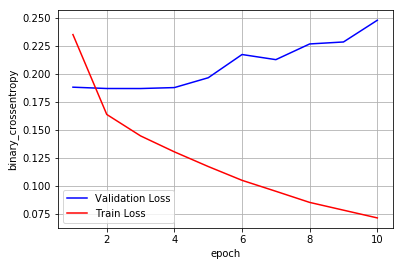

In [24]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Lstm two layer

In [25]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
epochs = 10

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           3736224   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,869,925
Trainable params: 3,869,925
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 254919 samples, validate on 109252 samples
Epoch 1/10


103424/254919 [===========>..................] - ETA: 1:00:06 - loss: 0.0732 - acc: 0.97 - ETA: 44:54 - loss: 0.1018 - acc: 0.9639 - ETA: 40:21 - loss: 0.0910 - acc: 0.96 - ETA: 38:25 - loss: 0.0870 - acc: 0.96 - ETA: 37:26 - loss: 0.0868 - acc: 0.96 - ETA: 36:30 - loss: 0.0858 - acc: 0.96 - ETA: 35:55 - loss: 0.0846 - acc: 0.97 - ETA: 35:16 - loss: 0.0846 - acc: 0.97 - ETA: 34:28 - loss: 0.0862 - acc: 0.97 - ETA: 33:48 - loss: 0.0836 - acc: 0.97 - ETA: 33:21 - loss: 0.0811 - acc: 0.97 - ETA: 32:56 - loss: 0.0836 - acc: 0.97 - ETA: 32:34 - loss: 0.0847 - acc: 0.97 - ETA: 32:12 - loss: 0.0834 - acc: 0.97 - ETA: 31:51 - loss: 0.0829 - acc: 0.97 - ETA: 31:35 - loss: 0.0856 - acc: 0.97 - ETA: 31:23 - loss: 0.0838 - acc: 0.97 - ETA: 31:23 - loss: 0.0817 - acc: 0.97 - ETA: 31:25 - loss: 0.0823 - acc: 0.97 - ETA: 31:18 - loss: 0.0832 - acc: 0.97 - ETA: 31:03 - loss: 0.0821 - acc: 0.97 - ETA: 30:50 - loss: 0.0815 - acc: 0.97 - ETA: 30:40 - loss: 0.0815 - acc: 0.97 - ETA: 30:29 - loss: 0.0814 -

207872/254919 [=======================>......] - ETA: 17:44 - loss: 0.0829 - acc: 0.97 - ETA: 17:40 - loss: 0.0830 - acc: 0.97 - ETA: 17:37 - loss: 0.0830 - acc: 0.97 - ETA: 17:33 - loss: 0.0829 - acc: 0.97 - ETA: 17:29 - loss: 0.0831 - acc: 0.97 - ETA: 17:26 - loss: 0.0831 - acc: 0.97 - ETA: 17:22 - loss: 0.0830 - acc: 0.97 - ETA: 17:19 - loss: 0.0831 - acc: 0.97 - ETA: 17:15 - loss: 0.0831 - acc: 0.97 - ETA: 17:11 - loss: 0.0834 - acc: 0.97 - ETA: 17:07 - loss: 0.0835 - acc: 0.97 - ETA: 17:04 - loss: 0.0835 - acc: 0.97 - ETA: 17:00 - loss: 0.0835 - acc: 0.97 - ETA: 16:57 - loss: 0.0835 - acc: 0.97 - ETA: 16:53 - loss: 0.0834 - acc: 0.97 - ETA: 16:49 - loss: 0.0834 - acc: 0.97 - ETA: 16:46 - loss: 0.0834 - acc: 0.97 - ETA: 16:42 - loss: 0.0834 - acc: 0.97 - ETA: 16:38 - loss: 0.0834 - acc: 0.97 - ETA: 16:35 - loss: 0.0834 - acc: 0.97 - ETA: 16:31 - loss: 0.0836 - acc: 0.97 - ETA: 16:27 - loss: 0.0835 - acc: 0.97 - ETA: 16:23 - loss: 0.0836 - acc: 0.97 - ETA: 16:20 - loss: 0.0837 - acc

254919/254919 [==============================] - ETA: 5:26 - loss: 0.0871 - acc: 0.969 - ETA: 5:23 - loss: 0.0871 - acc: 0.969 - ETA: 5:19 - loss: 0.0871 - acc: 0.969 - ETA: 5:15 - loss: 0.0871 - acc: 0.969 - ETA: 5:12 - loss: 0.0871 - acc: 0.968 - ETA: 5:08 - loss: 0.0871 - acc: 0.969 - ETA: 5:05 - loss: 0.0871 - acc: 0.969 - ETA: 5:01 - loss: 0.0870 - acc: 0.969 - ETA: 4:57 - loss: 0.0871 - acc: 0.968 - ETA: 4:54 - loss: 0.0871 - acc: 0.968 - ETA: 4:50 - loss: 0.0872 - acc: 0.968 - ETA: 4:47 - loss: 0.0872 - acc: 0.968 - ETA: 4:43 - loss: 0.0872 - acc: 0.968 - ETA: 4:39 - loss: 0.0872 - acc: 0.968 - ETA: 4:36 - loss: 0.0873 - acc: 0.968 - ETA: 4:32 - loss: 0.0872 - acc: 0.968 - ETA: 4:29 - loss: 0.0872 - acc: 0.968 - ETA: 4:25 - loss: 0.0873 - acc: 0.968 - ETA: 4:21 - loss: 0.0873 - acc: 0.968 - ETA: 4:18 - loss: 0.0873 - acc: 0.968 - ETA: 4:14 - loss: 0.0873 - acc: 0.968 - ETA: 4:11 - loss: 0.0873 - acc: 0.968 - ETA: 4:07 - loss: 0.0873 - acc: 0.968 - ETA: 4:03 - loss: 0.0873 - acc:

104448/254919 [===========>..................] - ETA: 31:06 - loss: 0.1023 - acc: 0.96 - ETA: 30:34 - loss: 0.0845 - acc: 0.97 - ETA: 30:17 - loss: 0.0840 - acc: 0.96 - ETA: 29:58 - loss: 0.0850 - acc: 0.96 - ETA: 30:30 - loss: 0.0872 - acc: 0.96 - ETA: 30:39 - loss: 0.0869 - acc: 0.96 - ETA: 30:24 - loss: 0.0834 - acc: 0.96 - ETA: 30:18 - loss: 0.0807 - acc: 0.97 - ETA: 30:11 - loss: 0.0778 - acc: 0.97 - ETA: 30:01 - loss: 0.0802 - acc: 0.97 - ETA: 29:54 - loss: 0.0784 - acc: 0.97 - ETA: 29:45 - loss: 0.0765 - acc: 0.97 - ETA: 29:32 - loss: 0.0748 - acc: 0.97 - ETA: 29:24 - loss: 0.0745 - acc: 0.97 - ETA: 29:18 - loss: 0.0752 - acc: 0.97 - ETA: 29:11 - loss: 0.0757 - acc: 0.97 - ETA: 29:05 - loss: 0.0747 - acc: 0.97 - ETA: 29:00 - loss: 0.0748 - acc: 0.97 - ETA: 28:55 - loss: 0.0764 - acc: 0.97 - ETA: 28:49 - loss: 0.0764 - acc: 0.97 - ETA: 28:49 - loss: 0.0774 - acc: 0.97 - ETA: 28:45 - loss: 0.0769 - acc: 0.97 - ETA: 28:42 - loss: 0.0771 - acc: 0.97 - ETA: 28:36 - loss: 0.0772 - acc

208896/254919 [=======================>......] - ETA: 17:35 - loss: 0.0814 - acc: 0.97 - ETA: 17:31 - loss: 0.0817 - acc: 0.97 - ETA: 17:28 - loss: 0.0817 - acc: 0.97 - ETA: 17:24 - loss: 0.0816 - acc: 0.97 - ETA: 17:21 - loss: 0.0816 - acc: 0.97 - ETA: 17:17 - loss: 0.0816 - acc: 0.97 - ETA: 17:14 - loss: 0.0815 - acc: 0.97 - ETA: 17:10 - loss: 0.0815 - acc: 0.97 - ETA: 17:06 - loss: 0.0814 - acc: 0.97 - ETA: 17:03 - loss: 0.0813 - acc: 0.97 - ETA: 16:59 - loss: 0.0813 - acc: 0.97 - ETA: 16:56 - loss: 0.0813 - acc: 0.97 - ETA: 16:52 - loss: 0.0813 - acc: 0.97 - ETA: 16:48 - loss: 0.0813 - acc: 0.97 - ETA: 16:45 - loss: 0.0812 - acc: 0.97 - ETA: 16:41 - loss: 0.0811 - acc: 0.97 - ETA: 16:37 - loss: 0.0811 - acc: 0.97 - ETA: 16:34 - loss: 0.0812 - acc: 0.97 - ETA: 16:30 - loss: 0.0811 - acc: 0.97 - ETA: 16:26 - loss: 0.0811 - acc: 0.97 - ETA: 16:23 - loss: 0.0811 - acc: 0.97 - ETA: 16:19 - loss: 0.0811 - acc: 0.97 - ETA: 16:16 - loss: 0.0811 - acc: 0.97 - ETA: 16:12 - loss: 0.0811 - acc

254919/254919 [==============================] - ETA: 5:18 - loss: 0.0817 - acc: 0.971 - ETA: 5:15 - loss: 0.0817 - acc: 0.971 - ETA: 5:11 - loss: 0.0817 - acc: 0.971 - ETA: 5:08 - loss: 0.0816 - acc: 0.971 - ETA: 5:04 - loss: 0.0817 - acc: 0.971 - ETA: 5:00 - loss: 0.0817 - acc: 0.971 - ETA: 4:57 - loss: 0.0817 - acc: 0.971 - ETA: 4:53 - loss: 0.0816 - acc: 0.971 - ETA: 4:50 - loss: 0.0816 - acc: 0.971 - ETA: 4:46 - loss: 0.0815 - acc: 0.971 - ETA: 4:42 - loss: 0.0815 - acc: 0.971 - ETA: 4:39 - loss: 0.0815 - acc: 0.971 - ETA: 4:35 - loss: 0.0815 - acc: 0.971 - ETA: 4:32 - loss: 0.0814 - acc: 0.971 - ETA: 4:28 - loss: 0.0814 - acc: 0.971 - ETA: 4:24 - loss: 0.0814 - acc: 0.971 - ETA: 4:21 - loss: 0.0815 - acc: 0.971 - ETA: 4:17 - loss: 0.0815 - acc: 0.971 - ETA: 4:14 - loss: 0.0815 - acc: 0.971 - ETA: 4:10 - loss: 0.0816 - acc: 0.971 - ETA: 4:06 - loss: 0.0815 - acc: 0.971 - ETA: 4:03 - loss: 0.0815 - acc: 0.971 - ETA: 3:59 - loss: 0.0816 - acc: 0.971 - ETA: 3:56 - loss: 0.0815 - acc:

104448/254919 [===========>..................] - ETA: 30:36 - loss: 0.0620 - acc: 0.98 - ETA: 30:32 - loss: 0.0687 - acc: 0.97 - ETA: 30:32 - loss: 0.0731 - acc: 0.97 - ETA: 30:08 - loss: 0.0692 - acc: 0.97 - ETA: 29:53 - loss: 0.0685 - acc: 0.97 - ETA: 29:47 - loss: 0.0687 - acc: 0.97 - ETA: 29:40 - loss: 0.0698 - acc: 0.97 - ETA: 29:36 - loss: 0.0689 - acc: 0.97 - ETA: 29:28 - loss: 0.0729 - acc: 0.97 - ETA: 29:21 - loss: 0.0721 - acc: 0.97 - ETA: 29:16 - loss: 0.0732 - acc: 0.97 - ETA: 29:14 - loss: 0.0752 - acc: 0.97 - ETA: 29:09 - loss: 0.0752 - acc: 0.97 - ETA: 29:03 - loss: 0.0747 - acc: 0.97 - ETA: 29:03 - loss: 0.0753 - acc: 0.97 - ETA: 28:58 - loss: 0.0738 - acc: 0.97 - ETA: 28:52 - loss: 0.0722 - acc: 0.97 - ETA: 28:46 - loss: 0.0717 - acc: 0.97 - ETA: 28:41 - loss: 0.0714 - acc: 0.97 - ETA: 28:37 - loss: 0.0713 - acc: 0.97 - ETA: 28:34 - loss: 0.0702 - acc: 0.97 - ETA: 28:29 - loss: 0.0695 - acc: 0.97 - ETA: 28:22 - loss: 0.0689 - acc: 0.97 - ETA: 28:17 - loss: 0.0682 - acc

208896/254919 [=======================>......] - ETA: 17:26 - loss: 0.0744 - acc: 0.97 - ETA: 17:23 - loss: 0.0745 - acc: 0.97 - ETA: 17:19 - loss: 0.0743 - acc: 0.97 - ETA: 17:15 - loss: 0.0743 - acc: 0.97 - ETA: 17:12 - loss: 0.0743 - acc: 0.97 - ETA: 17:08 - loss: 0.0744 - acc: 0.97 - ETA: 17:05 - loss: 0.0744 - acc: 0.97 - ETA: 17:01 - loss: 0.0743 - acc: 0.97 - ETA: 16:58 - loss: 0.0742 - acc: 0.97 - ETA: 16:54 - loss: 0.0743 - acc: 0.97 - ETA: 16:51 - loss: 0.0744 - acc: 0.97 - ETA: 16:47 - loss: 0.0745 - acc: 0.97 - ETA: 16:43 - loss: 0.0744 - acc: 0.97 - ETA: 16:40 - loss: 0.0744 - acc: 0.97 - ETA: 16:36 - loss: 0.0742 - acc: 0.97 - ETA: 16:33 - loss: 0.0743 - acc: 0.97 - ETA: 16:29 - loss: 0.0744 - acc: 0.97 - ETA: 16:25 - loss: 0.0743 - acc: 0.97 - ETA: 16:22 - loss: 0.0744 - acc: 0.97 - ETA: 16:18 - loss: 0.0744 - acc: 0.97 - ETA: 16:15 - loss: 0.0744 - acc: 0.97 - ETA: 16:11 - loss: 0.0745 - acc: 0.97 - ETA: 16:08 - loss: 0.0745 - acc: 0.97 - ETA: 16:04 - loss: 0.0746 - acc

254919/254919 [==============================] - ETA: 5:17 - loss: 0.0760 - acc: 0.973 - ETA: 5:14 - loss: 0.0761 - acc: 0.973 - ETA: 5:10 - loss: 0.0761 - acc: 0.973 - ETA: 5:07 - loss: 0.0761 - acc: 0.973 - ETA: 5:03 - loss: 0.0761 - acc: 0.973 - ETA: 5:00 - loss: 0.0762 - acc: 0.973 - ETA: 4:56 - loss: 0.0762 - acc: 0.973 - ETA: 4:52 - loss: 0.0762 - acc: 0.973 - ETA: 4:49 - loss: 0.0762 - acc: 0.973 - ETA: 4:45 - loss: 0.0762 - acc: 0.973 - ETA: 4:42 - loss: 0.0762 - acc: 0.973 - ETA: 4:38 - loss: 0.0762 - acc: 0.973 - ETA: 4:34 - loss: 0.0762 - acc: 0.973 - ETA: 4:31 - loss: 0.0762 - acc: 0.973 - ETA: 4:27 - loss: 0.0763 - acc: 0.973 - ETA: 4:24 - loss: 0.0762 - acc: 0.973 - ETA: 4:20 - loss: 0.0763 - acc: 0.973 - ETA: 4:17 - loss: 0.0763 - acc: 0.973 - ETA: 4:13 - loss: 0.0763 - acc: 0.973 - ETA: 4:09 - loss: 0.0763 - acc: 0.973 - ETA: 4:06 - loss: 0.0763 - acc: 0.973 - ETA: 4:02 - loss: 0.0763 - acc: 0.973 - ETA: 3:59 - loss: 0.0763 - acc: 0.973 - ETA: 3:55 - loss: 0.0763 - acc:

104448/254919 [===========>..................] - ETA: 31:05 - loss: 0.0763 - acc: 0.97 - ETA: 30:41 - loss: 0.0748 - acc: 0.97 - ETA: 30:26 - loss: 0.0677 - acc: 0.97 - ETA: 30:15 - loss: 0.0676 - acc: 0.97 - ETA: 30:03 - loss: 0.0675 - acc: 0.97 - ETA: 29:57 - loss: 0.0683 - acc: 0.97 - ETA: 29:46 - loss: 0.0677 - acc: 0.97 - ETA: 29:32 - loss: 0.0695 - acc: 0.97 - ETA: 29:26 - loss: 0.0682 - acc: 0.97 - ETA: 29:22 - loss: 0.0666 - acc: 0.97 - ETA: 29:21 - loss: 0.0660 - acc: 0.97 - ETA: 29:19 - loss: 0.0642 - acc: 0.97 - ETA: 29:16 - loss: 0.0655 - acc: 0.97 - ETA: 29:13 - loss: 0.0642 - acc: 0.97 - ETA: 29:07 - loss: 0.0632 - acc: 0.97 - ETA: 29:09 - loss: 0.0633 - acc: 0.97 - ETA: 29:09 - loss: 0.0638 - acc: 0.97 - ETA: 29:07 - loss: 0.0634 - acc: 0.97 - ETA: 29:03 - loss: 0.0647 - acc: 0.97 - ETA: 28:57 - loss: 0.0640 - acc: 0.97 - ETA: 28:51 - loss: 0.0636 - acc: 0.97 - ETA: 28:49 - loss: 0.0643 - acc: 0.97 - ETA: 28:44 - loss: 0.0644 - acc: 0.97 - ETA: 28:40 - loss: 0.0639 - acc

208896/254919 [=======================>......] - ETA: 17:32 - loss: 0.0681 - acc: 0.97 - ETA: 17:29 - loss: 0.0682 - acc: 0.97 - ETA: 17:25 - loss: 0.0682 - acc: 0.97 - ETA: 17:21 - loss: 0.0683 - acc: 0.97 - ETA: 17:18 - loss: 0.0685 - acc: 0.97 - ETA: 17:14 - loss: 0.0685 - acc: 0.97 - ETA: 17:11 - loss: 0.0685 - acc: 0.97 - ETA: 17:07 - loss: 0.0685 - acc: 0.97 - ETA: 17:04 - loss: 0.0686 - acc: 0.97 - ETA: 17:00 - loss: 0.0686 - acc: 0.97 - ETA: 16:56 - loss: 0.0686 - acc: 0.97 - ETA: 16:53 - loss: 0.0687 - acc: 0.97 - ETA: 16:49 - loss: 0.0687 - acc: 0.97 - ETA: 16:45 - loss: 0.0688 - acc: 0.97 - ETA: 16:42 - loss: 0.0689 - acc: 0.97 - ETA: 16:38 - loss: 0.0689 - acc: 0.97 - ETA: 16:34 - loss: 0.0691 - acc: 0.97 - ETA: 16:31 - loss: 0.0691 - acc: 0.97 - ETA: 16:27 - loss: 0.0692 - acc: 0.97 - ETA: 16:23 - loss: 0.0693 - acc: 0.97 - ETA: 16:20 - loss: 0.0695 - acc: 0.97 - ETA: 16:16 - loss: 0.0695 - acc: 0.97 - ETA: 16:12 - loss: 0.0696 - acc: 0.97 - ETA: 16:09 - loss: 0.0696 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0709 - acc: 0.974 - ETA: 5:16 - loss: 0.0710 - acc: 0.974 - ETA: 5:13 - loss: 0.0709 - acc: 0.974 - ETA: 5:09 - loss: 0.0710 - acc: 0.974 - ETA: 5:05 - loss: 0.0711 - acc: 0.974 - ETA: 5:02 - loss: 0.0711 - acc: 0.974 - ETA: 4:58 - loss: 0.0711 - acc: 0.974 - ETA: 4:55 - loss: 0.0711 - acc: 0.974 - ETA: 4:51 - loss: 0.0711 - acc: 0.974 - ETA: 4:47 - loss: 0.0712 - acc: 0.974 - ETA: 4:44 - loss: 0.0713 - acc: 0.974 - ETA: 4:40 - loss: 0.0713 - acc: 0.974 - ETA: 4:37 - loss: 0.0713 - acc: 0.974 - ETA: 4:33 - loss: 0.0714 - acc: 0.974 - ETA: 4:29 - loss: 0.0714 - acc: 0.974 - ETA: 4:26 - loss: 0.0714 - acc: 0.974 - ETA: 4:22 - loss: 0.0713 - acc: 0.974 - ETA: 4:19 - loss: 0.0713 - acc: 0.974 - ETA: 4:15 - loss: 0.0713 - acc: 0.974 - ETA: 4:11 - loss: 0.0713 - acc: 0.974 - ETA: 4:08 - loss: 0.0714 - acc: 0.974 - ETA: 4:04 - loss: 0.0714 - acc: 0.974 - ETA: 4:01 - loss: 0.0714 - acc: 0.974 - ETA: 3:57 - loss: 0.0714 - acc:

104448/254919 [===========>..................] - ETA: 32:47 - loss: 0.0861 - acc: 0.96 - ETA: 31:21 - loss: 0.0774 - acc: 0.96 - ETA: 30:44 - loss: 0.0751 - acc: 0.97 - ETA: 30:25 - loss: 0.0719 - acc: 0.97 - ETA: 30:22 - loss: 0.0713 - acc: 0.97 - ETA: 30:13 - loss: 0.0706 - acc: 0.97 - ETA: 30:00 - loss: 0.0683 - acc: 0.97 - ETA: 29:52 - loss: 0.0659 - acc: 0.97 - ETA: 29:45 - loss: 0.0701 - acc: 0.97 - ETA: 29:50 - loss: 0.0696 - acc: 0.97 - ETA: 29:45 - loss: 0.0670 - acc: 0.97 - ETA: 29:39 - loss: 0.0699 - acc: 0.97 - ETA: 29:33 - loss: 0.0689 - acc: 0.97 - ETA: 29:27 - loss: 0.0691 - acc: 0.97 - ETA: 29:22 - loss: 0.0666 - acc: 0.97 - ETA: 29:18 - loss: 0.0658 - acc: 0.97 - ETA: 29:13 - loss: 0.0655 - acc: 0.97 - ETA: 29:04 - loss: 0.0643 - acc: 0.97 - ETA: 28:58 - loss: 0.0636 - acc: 0.97 - ETA: 28:52 - loss: 0.0635 - acc: 0.97 - ETA: 28:47 - loss: 0.0631 - acc: 0.97 - ETA: 28:43 - loss: 0.0642 - acc: 0.97 - ETA: 28:39 - loss: 0.0635 - acc: 0.97 - ETA: 28:36 - loss: 0.0642 - acc

208896/254919 [=======================>......] - ETA: 17:40 - loss: 0.0657 - acc: 0.97 - ETA: 17:36 - loss: 0.0657 - acc: 0.97 - ETA: 17:33 - loss: 0.0657 - acc: 0.97 - ETA: 17:29 - loss: 0.0658 - acc: 0.97 - ETA: 17:25 - loss: 0.0659 - acc: 0.97 - ETA: 17:22 - loss: 0.0658 - acc: 0.97 - ETA: 17:18 - loss: 0.0658 - acc: 0.97 - ETA: 17:14 - loss: 0.0658 - acc: 0.97 - ETA: 17:11 - loss: 0.0659 - acc: 0.97 - ETA: 17:07 - loss: 0.0658 - acc: 0.97 - ETA: 17:03 - loss: 0.0657 - acc: 0.97 - ETA: 17:00 - loss: 0.0657 - acc: 0.97 - ETA: 16:56 - loss: 0.0657 - acc: 0.97 - ETA: 16:52 - loss: 0.0656 - acc: 0.97 - ETA: 16:49 - loss: 0.0656 - acc: 0.97 - ETA: 16:45 - loss: 0.0657 - acc: 0.97 - ETA: 16:41 - loss: 0.0656 - acc: 0.97 - ETA: 16:38 - loss: 0.0656 - acc: 0.97 - ETA: 16:34 - loss: 0.0657 - acc: 0.97 - ETA: 16:30 - loss: 0.0658 - acc: 0.97 - ETA: 16:27 - loss: 0.0658 - acc: 0.97 - ETA: 16:23 - loss: 0.0658 - acc: 0.97 - ETA: 16:19 - loss: 0.0657 - acc: 0.97 - ETA: 16:16 - loss: 0.0658 - acc

254919/254919 [==============================] - ETA: 5:21 - loss: 0.0669 - acc: 0.976 - ETA: 5:17 - loss: 0.0668 - acc: 0.976 - ETA: 5:14 - loss: 0.0668 - acc: 0.976 - ETA: 5:10 - loss: 0.0668 - acc: 0.976 - ETA: 5:06 - loss: 0.0668 - acc: 0.976 - ETA: 5:03 - loss: 0.0668 - acc: 0.976 - ETA: 4:59 - loss: 0.0668 - acc: 0.976 - ETA: 4:56 - loss: 0.0668 - acc: 0.976 - ETA: 4:52 - loss: 0.0669 - acc: 0.976 - ETA: 4:48 - loss: 0.0669 - acc: 0.976 - ETA: 4:45 - loss: 0.0669 - acc: 0.976 - ETA: 4:41 - loss: 0.0669 - acc: 0.976 - ETA: 4:37 - loss: 0.0670 - acc: 0.976 - ETA: 4:34 - loss: 0.0670 - acc: 0.976 - ETA: 4:30 - loss: 0.0670 - acc: 0.976 - ETA: 4:27 - loss: 0.0670 - acc: 0.976 - ETA: 4:23 - loss: 0.0672 - acc: 0.976 - ETA: 4:19 - loss: 0.0672 - acc: 0.976 - ETA: 4:16 - loss: 0.0671 - acc: 0.976 - ETA: 4:12 - loss: 0.0672 - acc: 0.976 - ETA: 4:09 - loss: 0.0673 - acc: 0.976 - ETA: 4:05 - loss: 0.0673 - acc: 0.976 - ETA: 4:01 - loss: 0.0672 - acc: 0.976 - ETA: 3:58 - loss: 0.0672 - acc:

104448/254919 [===========>..................] - ETA: 30:56 - loss: 0.0630 - acc: 0.97 - ETA: 30:30 - loss: 0.0752 - acc: 0.96 - ETA: 30:06 - loss: 0.0772 - acc: 0.96 - ETA: 30:10 - loss: 0.0723 - acc: 0.97 - ETA: 30:02 - loss: 0.0692 - acc: 0.97 - ETA: 29:51 - loss: 0.0664 - acc: 0.97 - ETA: 29:44 - loss: 0.0624 - acc: 0.97 - ETA: 29:41 - loss: 0.0606 - acc: 0.97 - ETA: 29:35 - loss: 0.0601 - acc: 0.97 - ETA: 29:29 - loss: 0.0609 - acc: 0.97 - ETA: 29:24 - loss: 0.0607 - acc: 0.97 - ETA: 29:14 - loss: 0.0581 - acc: 0.97 - ETA: 29:11 - loss: 0.0591 - acc: 0.97 - ETA: 29:06 - loss: 0.0587 - acc: 0.97 - ETA: 29:04 - loss: 0.0590 - acc: 0.97 - ETA: 29:00 - loss: 0.0578 - acc: 0.97 - ETA: 28:55 - loss: 0.0578 - acc: 0.97 - ETA: 28:51 - loss: 0.0594 - acc: 0.97 - ETA: 28:47 - loss: 0.0585 - acc: 0.97 - ETA: 28:43 - loss: 0.0582 - acc: 0.97 - ETA: 28:34 - loss: 0.0578 - acc: 0.97 - ETA: 28:31 - loss: 0.0585 - acc: 0.97 - ETA: 28:27 - loss: 0.0590 - acc: 0.97 - ETA: 28:23 - loss: 0.0584 - acc

208896/254919 [=======================>......] - ETA: 17:37 - loss: 0.0608 - acc: 0.97 - ETA: 17:33 - loss: 0.0608 - acc: 0.97 - ETA: 17:29 - loss: 0.0610 - acc: 0.97 - ETA: 17:26 - loss: 0.0611 - acc: 0.97 - ETA: 17:22 - loss: 0.0612 - acc: 0.97 - ETA: 17:18 - loss: 0.0612 - acc: 0.97 - ETA: 17:15 - loss: 0.0612 - acc: 0.97 - ETA: 17:11 - loss: 0.0611 - acc: 0.97 - ETA: 17:07 - loss: 0.0611 - acc: 0.97 - ETA: 17:04 - loss: 0.0611 - acc: 0.97 - ETA: 17:00 - loss: 0.0611 - acc: 0.97 - ETA: 16:57 - loss: 0.0614 - acc: 0.97 - ETA: 16:53 - loss: 0.0614 - acc: 0.97 - ETA: 16:49 - loss: 0.0615 - acc: 0.97 - ETA: 16:46 - loss: 0.0615 - acc: 0.97 - ETA: 16:42 - loss: 0.0615 - acc: 0.97 - ETA: 16:39 - loss: 0.0615 - acc: 0.97 - ETA: 16:35 - loss: 0.0615 - acc: 0.97 - ETA: 16:31 - loss: 0.0614 - acc: 0.97 - ETA: 16:28 - loss: 0.0613 - acc: 0.97 - ETA: 16:25 - loss: 0.0613 - acc: 0.97 - ETA: 16:21 - loss: 0.0614 - acc: 0.97 - ETA: 16:17 - loss: 0.0615 - acc: 0.97 - ETA: 16:14 - loss: 0.0616 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0639 - acc: 0.977 - ETA: 5:17 - loss: 0.0640 - acc: 0.977 - ETA: 5:13 - loss: 0.0640 - acc: 0.977 - ETA: 5:09 - loss: 0.0640 - acc: 0.977 - ETA: 5:06 - loss: 0.0640 - acc: 0.977 - ETA: 5:02 - loss: 0.0639 - acc: 0.977 - ETA: 4:59 - loss: 0.0640 - acc: 0.977 - ETA: 4:55 - loss: 0.0640 - acc: 0.977 - ETA: 4:51 - loss: 0.0640 - acc: 0.977 - ETA: 4:48 - loss: 0.0640 - acc: 0.977 - ETA: 4:44 - loss: 0.0640 - acc: 0.977 - ETA: 4:41 - loss: 0.0640 - acc: 0.977 - ETA: 4:37 - loss: 0.0640 - acc: 0.977 - ETA: 4:33 - loss: 0.0640 - acc: 0.977 - ETA: 4:30 - loss: 0.0640 - acc: 0.977 - ETA: 4:26 - loss: 0.0640 - acc: 0.977 - ETA: 4:23 - loss: 0.0640 - acc: 0.977 - ETA: 4:19 - loss: 0.0640 - acc: 0.977 - ETA: 4:15 - loss: 0.0640 - acc: 0.977 - ETA: 4:12 - loss: 0.0640 - acc: 0.977 - ETA: 4:08 - loss: 0.0640 - acc: 0.977 - ETA: 4:04 - loss: 0.0640 - acc: 0.977 - ETA: 4:01 - loss: 0.0640 - acc: 0.977 - ETA: 3:57 - loss: 0.0640 - acc:

104448/254919 [===========>..................] - ETA: 33:43 - loss: 0.0641 - acc: 0.97 - ETA: 32:27 - loss: 0.0567 - acc: 0.98 - ETA: 31:39 - loss: 0.0532 - acc: 0.98 - ETA: 31:13 - loss: 0.0494 - acc: 0.98 - ETA: 31:00 - loss: 0.0460 - acc: 0.98 - ETA: 30:35 - loss: 0.0480 - acc: 0.98 - ETA: 30:27 - loss: 0.0521 - acc: 0.98 - ETA: 30:20 - loss: 0.0511 - acc: 0.98 - ETA: 30:17 - loss: 0.0530 - acc: 0.98 - ETA: 30:16 - loss: 0.0519 - acc: 0.98 - ETA: 30:11 - loss: 0.0534 - acc: 0.98 - ETA: 30:04 - loss: 0.0521 - acc: 0.98 - ETA: 30:01 - loss: 0.0533 - acc: 0.98 - ETA: 29:58 - loss: 0.0558 - acc: 0.98 - ETA: 29:56 - loss: 0.0564 - acc: 0.98 - ETA: 29:51 - loss: 0.0567 - acc: 0.98 - ETA: 29:42 - loss: 0.0569 - acc: 0.98 - ETA: 29:35 - loss: 0.0558 - acc: 0.98 - ETA: 29:30 - loss: 0.0557 - acc: 0.98 - ETA: 29:25 - loss: 0.0541 - acc: 0.98 - ETA: 29:20 - loss: 0.0535 - acc: 0.98 - ETA: 29:15 - loss: 0.0543 - acc: 0.98 - ETA: 29:12 - loss: 0.0540 - acc: 0.98 - ETA: 29:08 - loss: 0.0543 - acc

208896/254919 [=======================>......] - ETA: 17:35 - loss: 0.0583 - acc: 0.97 - ETA: 17:31 - loss: 0.0583 - acc: 0.97 - ETA: 17:27 - loss: 0.0583 - acc: 0.97 - ETA: 17:24 - loss: 0.0584 - acc: 0.97 - ETA: 17:20 - loss: 0.0584 - acc: 0.97 - ETA: 17:17 - loss: 0.0584 - acc: 0.97 - ETA: 17:13 - loss: 0.0584 - acc: 0.97 - ETA: 17:09 - loss: 0.0584 - acc: 0.97 - ETA: 17:06 - loss: 0.0584 - acc: 0.97 - ETA: 17:02 - loss: 0.0584 - acc: 0.97 - ETA: 16:58 - loss: 0.0584 - acc: 0.97 - ETA: 16:55 - loss: 0.0583 - acc: 0.97 - ETA: 16:51 - loss: 0.0583 - acc: 0.97 - ETA: 16:48 - loss: 0.0583 - acc: 0.97 - ETA: 16:44 - loss: 0.0582 - acc: 0.97 - ETA: 16:40 - loss: 0.0582 - acc: 0.97 - ETA: 16:36 - loss: 0.0582 - acc: 0.97 - ETA: 16:33 - loss: 0.0581 - acc: 0.97 - ETA: 16:29 - loss: 0.0581 - acc: 0.97 - ETA: 16:25 - loss: 0.0582 - acc: 0.97 - ETA: 16:22 - loss: 0.0581 - acc: 0.97 - ETA: 16:18 - loss: 0.0581 - acc: 0.97 - ETA: 16:14 - loss: 0.0580 - acc: 0.97 - ETA: 16:10 - loss: 0.0580 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0604 - acc: 0.978 - ETA: 5:16 - loss: 0.0604 - acc: 0.978 - ETA: 5:13 - loss: 0.0603 - acc: 0.979 - ETA: 5:09 - loss: 0.0604 - acc: 0.979 - ETA: 5:06 - loss: 0.0604 - acc: 0.979 - ETA: 5:02 - loss: 0.0603 - acc: 0.979 - ETA: 4:58 - loss: 0.0604 - acc: 0.978 - ETA: 4:55 - loss: 0.0604 - acc: 0.978 - ETA: 4:51 - loss: 0.0604 - acc: 0.978 - ETA: 4:48 - loss: 0.0604 - acc: 0.978 - ETA: 4:44 - loss: 0.0603 - acc: 0.978 - ETA: 4:40 - loss: 0.0603 - acc: 0.978 - ETA: 4:37 - loss: 0.0604 - acc: 0.978 - ETA: 4:33 - loss: 0.0604 - acc: 0.978 - ETA: 4:29 - loss: 0.0604 - acc: 0.978 - ETA: 4:26 - loss: 0.0604 - acc: 0.978 - ETA: 4:22 - loss: 0.0604 - acc: 0.978 - ETA: 4:19 - loss: 0.0604 - acc: 0.979 - ETA: 4:15 - loss: 0.0604 - acc: 0.979 - ETA: 4:11 - loss: 0.0604 - acc: 0.979 - ETA: 4:08 - loss: 0.0604 - acc: 0.979 - ETA: 4:04 - loss: 0.0604 - acc: 0.979 - ETA: 4:01 - loss: 0.0604 - acc: 0.979 - ETA: 3:57 - loss: 0.0604 - acc:

104448/254919 [===========>..................] - ETA: 29:52 - loss: 0.0550 - acc: 0.97 - ETA: 29:48 - loss: 0.0592 - acc: 0.98 - ETA: 29:43 - loss: 0.0627 - acc: 0.98 - ETA: 29:37 - loss: 0.0574 - acc: 0.98 - ETA: 29:36 - loss: 0.0541 - acc: 0.98 - ETA: 29:30 - loss: 0.0547 - acc: 0.98 - ETA: 29:22 - loss: 0.0583 - acc: 0.98 - ETA: 29:39 - loss: 0.0602 - acc: 0.98 - ETA: 29:36 - loss: 0.0623 - acc: 0.98 - ETA: 29:31 - loss: 0.0602 - acc: 0.98 - ETA: 29:26 - loss: 0.0580 - acc: 0.98 - ETA: 29:21 - loss: 0.0571 - acc: 0.98 - ETA: 29:14 - loss: 0.0573 - acc: 0.98 - ETA: 29:14 - loss: 0.0561 - acc: 0.98 - ETA: 29:09 - loss: 0.0555 - acc: 0.98 - ETA: 29:03 - loss: 0.0567 - acc: 0.98 - ETA: 29:08 - loss: 0.0564 - acc: 0.98 - ETA: 29:03 - loss: 0.0558 - acc: 0.98 - ETA: 29:05 - loss: 0.0556 - acc: 0.98 - ETA: 28:58 - loss: 0.0564 - acc: 0.98 - ETA: 28:55 - loss: 0.0563 - acc: 0.98 - ETA: 28:50 - loss: 0.0573 - acc: 0.98 - ETA: 28:45 - loss: 0.0574 - acc: 0.98 - ETA: 28:43 - loss: 0.0571 - acc

208896/254919 [=======================>......] - ETA: 17:37 - loss: 0.0563 - acc: 0.98 - ETA: 17:34 - loss: 0.0563 - acc: 0.98 - ETA: 17:30 - loss: 0.0563 - acc: 0.98 - ETA: 17:26 - loss: 0.0564 - acc: 0.98 - ETA: 17:23 - loss: 0.0564 - acc: 0.98 - ETA: 17:19 - loss: 0.0564 - acc: 0.98 - ETA: 17:15 - loss: 0.0563 - acc: 0.98 - ETA: 17:12 - loss: 0.0564 - acc: 0.98 - ETA: 17:08 - loss: 0.0564 - acc: 0.98 - ETA: 17:05 - loss: 0.0565 - acc: 0.98 - ETA: 17:01 - loss: 0.0564 - acc: 0.98 - ETA: 16:57 - loss: 0.0563 - acc: 0.98 - ETA: 16:54 - loss: 0.0564 - acc: 0.98 - ETA: 16:50 - loss: 0.0564 - acc: 0.98 - ETA: 16:47 - loss: 0.0563 - acc: 0.98 - ETA: 16:43 - loss: 0.0566 - acc: 0.98 - ETA: 16:39 - loss: 0.0566 - acc: 0.98 - ETA: 16:35 - loss: 0.0566 - acc: 0.98 - ETA: 16:32 - loss: 0.0566 - acc: 0.98 - ETA: 16:28 - loss: 0.0565 - acc: 0.98 - ETA: 16:25 - loss: 0.0564 - acc: 0.98 - ETA: 16:21 - loss: 0.0564 - acc: 0.98 - ETA: 16:18 - loss: 0.0564 - acc: 0.98 - ETA: 16:14 - loss: 0.0565 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0586 - acc: 0.979 - ETA: 5:17 - loss: 0.0586 - acc: 0.979 - ETA: 5:13 - loss: 0.0586 - acc: 0.979 - ETA: 5:09 - loss: 0.0587 - acc: 0.979 - ETA: 5:06 - loss: 0.0586 - acc: 0.979 - ETA: 5:02 - loss: 0.0586 - acc: 0.979 - ETA: 4:59 - loss: 0.0587 - acc: 0.979 - ETA: 4:55 - loss: 0.0587 - acc: 0.979 - ETA: 4:51 - loss: 0.0587 - acc: 0.979 - ETA: 4:48 - loss: 0.0587 - acc: 0.979 - ETA: 4:44 - loss: 0.0586 - acc: 0.979 - ETA: 4:40 - loss: 0.0587 - acc: 0.979 - ETA: 4:37 - loss: 0.0587 - acc: 0.979 - ETA: 4:33 - loss: 0.0587 - acc: 0.979 - ETA: 4:30 - loss: 0.0588 - acc: 0.979 - ETA: 4:26 - loss: 0.0588 - acc: 0.979 - ETA: 4:22 - loss: 0.0588 - acc: 0.979 - ETA: 4:19 - loss: 0.0588 - acc: 0.979 - ETA: 4:15 - loss: 0.0588 - acc: 0.979 - ETA: 4:12 - loss: 0.0588 - acc: 0.979 - ETA: 4:08 - loss: 0.0589 - acc: 0.979 - ETA: 4:04 - loss: 0.0589 - acc: 0.979 - ETA: 4:01 - loss: 0.0588 - acc: 0.979 - ETA: 3:57 - loss: 0.0588 - acc:

104448/254919 [===========>..................] - ETA: 29:56 - loss: 0.0456 - acc: 0.98 - ETA: 30:28 - loss: 0.0564 - acc: 0.97 - ETA: 30:13 - loss: 0.0603 - acc: 0.98 - ETA: 29:53 - loss: 0.0566 - acc: 0.98 - ETA: 29:43 - loss: 0.0597 - acc: 0.98 - ETA: 29:42 - loss: 0.0640 - acc: 0.98 - ETA: 29:46 - loss: 0.0604 - acc: 0.98 - ETA: 29:38 - loss: 0.0592 - acc: 0.98 - ETA: 29:33 - loss: 0.0572 - acc: 0.98 - ETA: 29:18 - loss: 0.0563 - acc: 0.98 - ETA: 29:12 - loss: 0.0569 - acc: 0.98 - ETA: 29:06 - loss: 0.0568 - acc: 0.98 - ETA: 29:03 - loss: 0.0560 - acc: 0.98 - ETA: 28:59 - loss: 0.0546 - acc: 0.98 - ETA: 28:56 - loss: 0.0538 - acc: 0.98 - ETA: 28:52 - loss: 0.0535 - acc: 0.98 - ETA: 28:48 - loss: 0.0533 - acc: 0.98 - ETA: 28:43 - loss: 0.0539 - acc: 0.98 - ETA: 28:34 - loss: 0.0524 - acc: 0.98 - ETA: 28:30 - loss: 0.0526 - acc: 0.98 - ETA: 28:27 - loss: 0.0523 - acc: 0.98 - ETA: 28:26 - loss: 0.0520 - acc: 0.98 - ETA: 28:21 - loss: 0.0516 - acc: 0.98 - ETA: 28:19 - loss: 0.0505 - acc

208896/254919 [=======================>......] - ETA: 17:37 - loss: 0.0527 - acc: 0.98 - ETA: 17:33 - loss: 0.0527 - acc: 0.98 - ETA: 17:30 - loss: 0.0527 - acc: 0.98 - ETA: 17:26 - loss: 0.0527 - acc: 0.98 - ETA: 17:23 - loss: 0.0527 - acc: 0.98 - ETA: 17:19 - loss: 0.0527 - acc: 0.98 - ETA: 17:15 - loss: 0.0527 - acc: 0.98 - ETA: 17:12 - loss: 0.0526 - acc: 0.98 - ETA: 17:08 - loss: 0.0526 - acc: 0.98 - ETA: 17:04 - loss: 0.0525 - acc: 0.98 - ETA: 17:01 - loss: 0.0527 - acc: 0.98 - ETA: 16:57 - loss: 0.0528 - acc: 0.98 - ETA: 16:53 - loss: 0.0527 - acc: 0.98 - ETA: 16:50 - loss: 0.0527 - acc: 0.98 - ETA: 16:46 - loss: 0.0526 - acc: 0.98 - ETA: 16:42 - loss: 0.0527 - acc: 0.98 - ETA: 16:39 - loss: 0.0528 - acc: 0.98 - ETA: 16:35 - loss: 0.0529 - acc: 0.98 - ETA: 16:32 - loss: 0.0530 - acc: 0.98 - ETA: 16:28 - loss: 0.0532 - acc: 0.98 - ETA: 16:24 - loss: 0.0531 - acc: 0.98 - ETA: 16:21 - loss: 0.0529 - acc: 0.98 - ETA: 16:17 - loss: 0.0529 - acc: 0.98 - ETA: 16:14 - loss: 0.0529 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0552 - acc: 0.981 - ETA: 5:17 - loss: 0.0552 - acc: 0.981 - ETA: 5:13 - loss: 0.0553 - acc: 0.980 - ETA: 5:09 - loss: 0.0553 - acc: 0.980 - ETA: 5:06 - loss: 0.0553 - acc: 0.980 - ETA: 5:02 - loss: 0.0553 - acc: 0.980 - ETA: 4:59 - loss: 0.0553 - acc: 0.980 - ETA: 4:55 - loss: 0.0554 - acc: 0.980 - ETA: 4:51 - loss: 0.0553 - acc: 0.980 - ETA: 4:48 - loss: 0.0554 - acc: 0.980 - ETA: 4:44 - loss: 0.0553 - acc: 0.980 - ETA: 4:41 - loss: 0.0554 - acc: 0.980 - ETA: 4:37 - loss: 0.0554 - acc: 0.980 - ETA: 4:33 - loss: 0.0554 - acc: 0.980 - ETA: 4:30 - loss: 0.0554 - acc: 0.980 - ETA: 4:26 - loss: 0.0554 - acc: 0.980 - ETA: 4:23 - loss: 0.0553 - acc: 0.980 - ETA: 4:19 - loss: 0.0553 - acc: 0.980 - ETA: 4:15 - loss: 0.0554 - acc: 0.980 - ETA: 4:12 - loss: 0.0554 - acc: 0.980 - ETA: 4:08 - loss: 0.0554 - acc: 0.980 - ETA: 4:05 - loss: 0.0554 - acc: 0.980 - ETA: 4:01 - loss: 0.0554 - acc: 0.980 - ETA: 3:57 - loss: 0.0554 - acc:

104448/254919 [===========>..................] - ETA: 30:19 - loss: 0.0772 - acc: 0.98 - ETA: 30:10 - loss: 0.0611 - acc: 0.98 - ETA: 30:00 - loss: 0.0542 - acc: 0.98 - ETA: 29:33 - loss: 0.0524 - acc: 0.98 - ETA: 29:22 - loss: 0.0502 - acc: 0.98 - ETA: 29:20 - loss: 0.0492 - acc: 0.98 - ETA: 29:17 - loss: 0.0507 - acc: 0.98 - ETA: 29:13 - loss: 0.0502 - acc: 0.98 - ETA: 29:12 - loss: 0.0477 - acc: 0.98 - ETA: 29:10 - loss: 0.0455 - acc: 0.98 - ETA: 29:07 - loss: 0.0455 - acc: 0.98 - ETA: 29:08 - loss: 0.0462 - acc: 0.98 - ETA: 29:07 - loss: 0.0464 - acc: 0.98 - ETA: 29:02 - loss: 0.0487 - acc: 0.98 - ETA: 28:58 - loss: 0.0494 - acc: 0.98 - ETA: 28:54 - loss: 0.0492 - acc: 0.98 - ETA: 28:50 - loss: 0.0485 - acc: 0.98 - ETA: 28:47 - loss: 0.0490 - acc: 0.98 - ETA: 28:42 - loss: 0.0493 - acc: 0.98 - ETA: 28:38 - loss: 0.0485 - acc: 0.98 - ETA: 28:35 - loss: 0.0486 - acc: 0.98 - ETA: 28:33 - loss: 0.0491 - acc: 0.98 - ETA: 28:31 - loss: 0.0500 - acc: 0.98 - ETA: 28:27 - loss: 0.0494 - acc

208896/254919 [=======================>......] - ETA: 17:35 - loss: 0.0506 - acc: 0.98 - ETA: 17:31 - loss: 0.0507 - acc: 0.98 - ETA: 17:27 - loss: 0.0506 - acc: 0.98 - ETA: 17:24 - loss: 0.0507 - acc: 0.98 - ETA: 17:20 - loss: 0.0506 - acc: 0.98 - ETA: 17:16 - loss: 0.0506 - acc: 0.98 - ETA: 17:13 - loss: 0.0506 - acc: 0.98 - ETA: 17:09 - loss: 0.0505 - acc: 0.98 - ETA: 17:06 - loss: 0.0506 - acc: 0.98 - ETA: 17:02 - loss: 0.0507 - acc: 0.98 - ETA: 16:58 - loss: 0.0506 - acc: 0.98 - ETA: 16:55 - loss: 0.0506 - acc: 0.98 - ETA: 16:51 - loss: 0.0507 - acc: 0.98 - ETA: 16:47 - loss: 0.0506 - acc: 0.98 - ETA: 16:44 - loss: 0.0507 - acc: 0.98 - ETA: 16:40 - loss: 0.0507 - acc: 0.98 - ETA: 16:37 - loss: 0.0508 - acc: 0.98 - ETA: 16:33 - loss: 0.0508 - acc: 0.98 - ETA: 16:30 - loss: 0.0509 - acc: 0.98 - ETA: 16:26 - loss: 0.0508 - acc: 0.98 - ETA: 16:23 - loss: 0.0508 - acc: 0.98 - ETA: 16:19 - loss: 0.0508 - acc: 0.98 - ETA: 16:15 - loss: 0.0508 - acc: 0.98 - ETA: 16:12 - loss: 0.0509 - acc

254919/254919 [==============================] - ETA: 5:20 - loss: 0.0522 - acc: 0.981 - ETA: 5:16 - loss: 0.0522 - acc: 0.981 - ETA: 5:13 - loss: 0.0522 - acc: 0.981 - ETA: 5:09 - loss: 0.0522 - acc: 0.981 - ETA: 5:05 - loss: 0.0523 - acc: 0.981 - ETA: 5:02 - loss: 0.0523 - acc: 0.981 - ETA: 4:58 - loss: 0.0523 - acc: 0.981 - ETA: 4:55 - loss: 0.0523 - acc: 0.981 - ETA: 4:51 - loss: 0.0524 - acc: 0.981 - ETA: 4:47 - loss: 0.0524 - acc: 0.981 - ETA: 4:44 - loss: 0.0524 - acc: 0.981 - ETA: 4:40 - loss: 0.0524 - acc: 0.981 - ETA: 4:37 - loss: 0.0524 - acc: 0.981 - ETA: 4:33 - loss: 0.0524 - acc: 0.981 - ETA: 4:29 - loss: 0.0524 - acc: 0.981 - ETA: 4:26 - loss: 0.0525 - acc: 0.981 - ETA: 4:22 - loss: 0.0525 - acc: 0.981 - ETA: 4:19 - loss: 0.0525 - acc: 0.981 - ETA: 4:15 - loss: 0.0525 - acc: 0.981 - ETA: 4:11 - loss: 0.0525 - acc: 0.981 - ETA: 4:08 - loss: 0.0525 - acc: 0.981 - ETA: 4:04 - loss: 0.0525 - acc: 0.981 - ETA: 4:01 - loss: 0.0524 - acc: 0.981 - ETA: 3:57 - loss: 0.0525 - acc:

Test score: 0.2632932605560837
Test accuracy: 0.9275162010764105


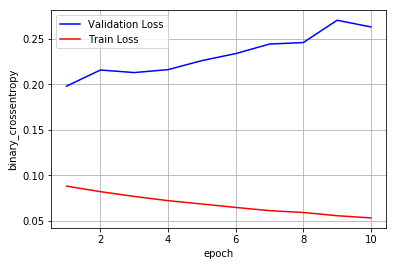

In [33]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [35]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["RNN_MODEL", "TRAIN_ACCURACY", "TEST_ACCURACY"]
x.add_row(["LSTM", 0.976, 0.928])
x.add_row(["LSTM(2-hidden layers)", 0.968, 0.934])

print('           RNN WITH DIFFERNET ARCHITECTURES')
print(x)

           RNN WITH DIFFERNET ARCHITECTURES
+-----------------------+----------------+---------------+
|       RNN_MODEL       | TRAIN_ACCURACY | TEST_ACCURACY |
+-----------------------+----------------+---------------+
|          LSTM         |     0.976      |     0.928     |
| LSTM(2-hidden layers) |     0.968      |     0.934     |
+-----------------------+----------------+---------------+
